# Project: Segmentation of space objects

## 1. Problem Statmenet

You are a CV specialist at a startup, tasked with building a model to predict the trajectory of active space objects to avoid collisions with space debris. Your task is to segment images of artificial satellites and space stations, achieving an mIoU metric value of >70% on the validation set.

## 2. Import Libraries and Define Constants

In [27]:
import albumentations as A
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
import numpy as np
import os

from PIL import Image
from tqdm import tqdm

from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torchvision.models.segmentation import deeplabv3_resnet50
from sklearn.model_selection import train_test_split

is_debug_mode = False
print('Mode:', 'debug' if is_debug_mode else 'release')

img_size = 256 if is_debug_mode else 512
print('Image size: ', img_size)

num_epochs = 5 if is_debug_mode else 5
print('Num epochs:', num_epochs)

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

batch_size = 4

images_dir = 'data/images/'
mask_dir = 'data/mask/'

Mode: release
Image size:  512
Num epochs: 5
Using device: mps


## 3. Loading Data

Define a custom dataset to load satelites data.

In [28]:
COLOR_TO_CLASS = {
    (0,   0,   0): 0,  # background
    (255, 0,   0): 1,  # red
    (0,   255, 0): 2,  # green
    (0,   0,   255): 3 # blue
}


def rgb_to_class(mask_np):
    h, w, _ = mask_np.shape
    class_mask = np.zeros((h, w), dtype=np.int64)

    for rgb, cls in COLOR_TO_CLASS.items():
        matches = np.all(mask_np == rgb, axis=-1)
        class_mask[matches] = cls

    return class_mask


In [29]:
class SattDataset(Dataset):
    def __init__(self, image_dir, mask_dir, split="train", transform=None):
        self.images_filenames = os.listdir(image_dir + split) 
        self.transform = transform
        
        self.image_dir = image_dir + split
        self.mask_dir = mask_dir + split

        self.normalize = T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )


    def __len__(self):
        return len(self.images_filenames)


    def __getitem__(self, idx):
        image_name = self.images_filenames[idx]
        mask_name = image_name.replace('.png', '_mask.png')

        image = Image.open(os.path.join(self.image_dir, image_name)).convert("RGB")
        mask  = Image.open(os.path.join(self.mask_dir, mask_name)).convert("RGB")
        #print('Loaded image:', image_name, 'mask:', mask_name)
        
        image_np = np.array(image)
        mask_np  = np.array(mask)

        if self.transform:
            augmented = self.transform(image=image_np, mask=mask_np)
            image_np = augmented["image"]
            mask_np  = augmented["mask"]

        # IMAGE → tensor
        image = TF.to_tensor(image_np)
        image = self.normalize(image)

        # MASK → class indices (NO to_tensor!)
        mask = rgb_to_class(mask_np)
        mask = torch.from_numpy(mask).long()  # [H,W]

        return image, mask

Define transformations for traning and validation; and augmentations for training.

In [30]:
train_transform = A.Compose([
    A.Resize(img_size, img_size),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
], additional_targets={'mask': 'mask'})

val_transform = A.Compose([
    A.Resize(img_size, img_size)
], additional_targets={'mask': 'mask'})

/Users/dmitriygolubitskiy/Library/Mobile Documents/com~apple~CloudDocs/Documents/Technology/Data Science/IDE2/DataCleaningProject/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Loading datasets and defining data loaders.

For development and debugging I use Subsets of data to get results faster.

In [31]:
dataset_train = SattDataset(
    images_dir, 
    mask_dir, 
    transform=train_transform,
    split="train"
)
if is_debug_mode:
    dataset_train = torch.utils.data.Subset(dataset_train, range(400))

dataset_val = SattDataset(
    images_dir, 
    mask_dir, 
    transform=val_transform,
    split="val"
)
if is_debug_mode:
    dataset_val = torch.utils.data.Subset(dataset_val, range(100))

train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=4, shuffle=False)

In [32]:
image, mask = dataset_train[0]
image.shape, mask.shape

(torch.Size([3, 512, 512]), torch.Size([512, 512]))

Training dataset


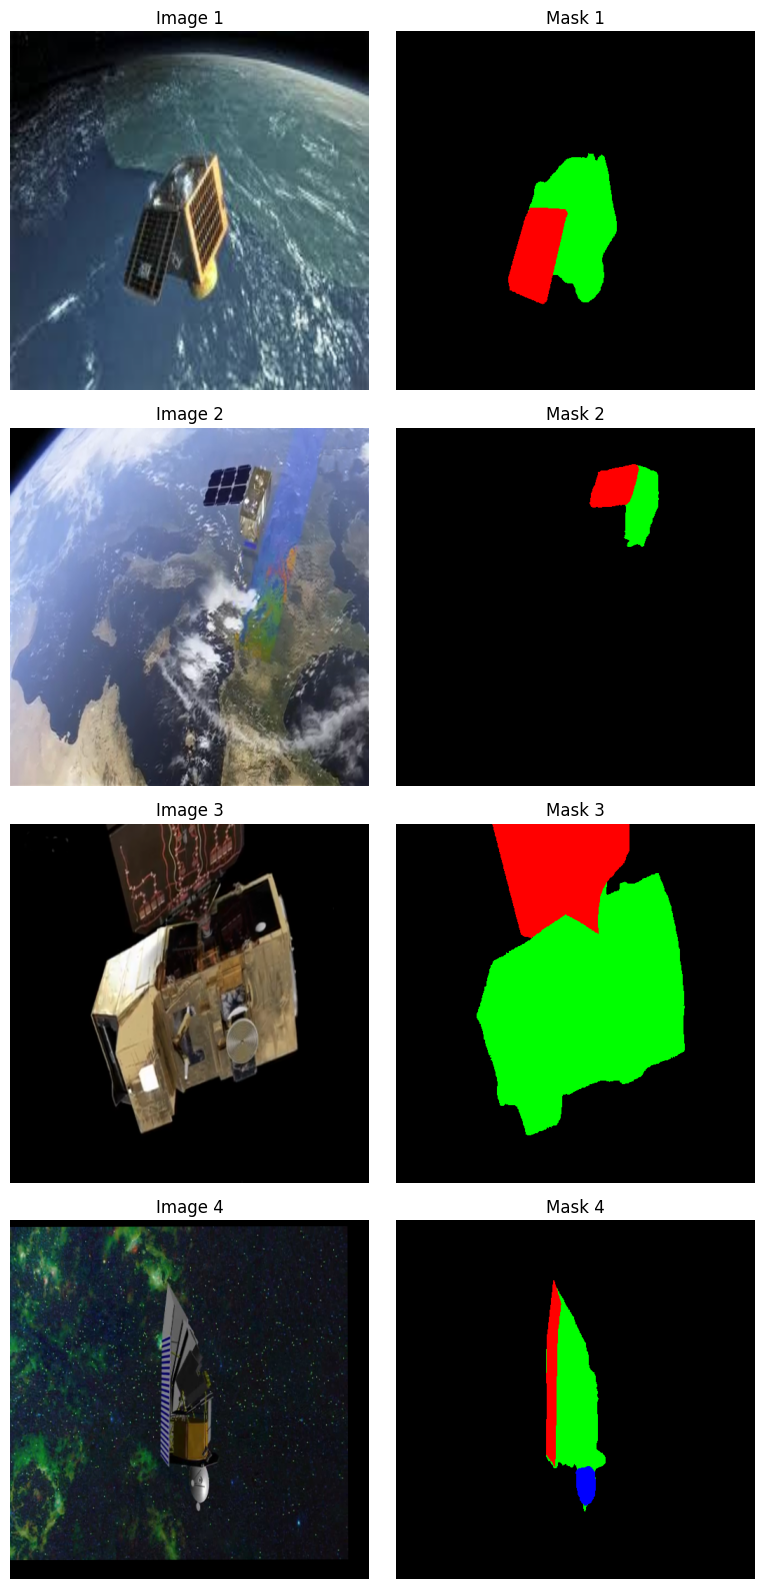

Validation dataset


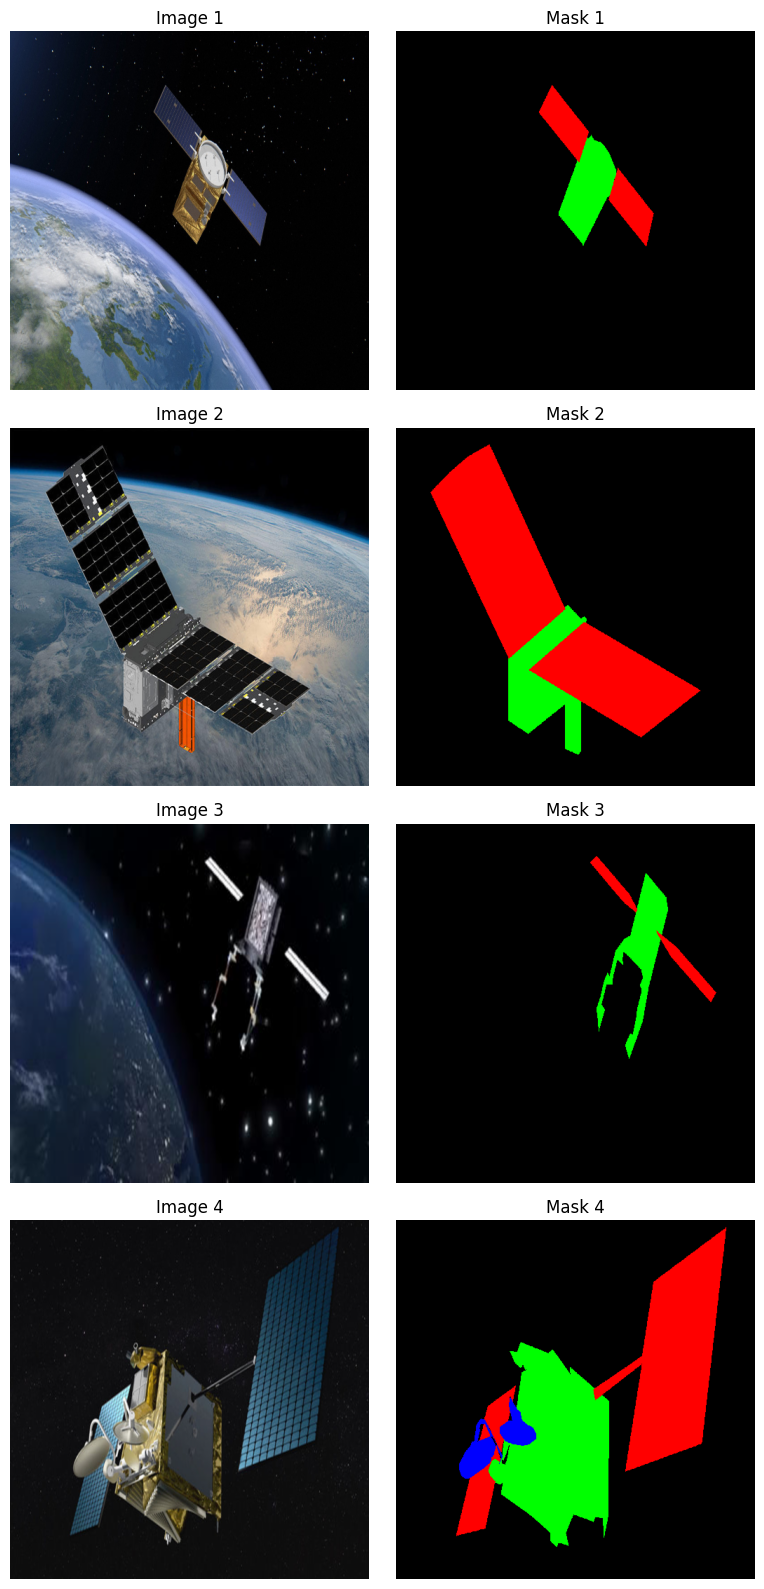

In [33]:
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return img * std + mean

COLORS = np.array([
    [0,   0,   0],    # 0 background
    [255, 0,   0],    # 1 red
    [0,   255, 0],    # 2 green
    [0,   0,   255],  # 3 blue
], dtype=np.uint8)

def colorize_mask(mask):
    return COLORS[mask]

def plot_samples(dataset, num_samples=4):
    fig, axes = plt.subplots(4, 2, figsize=(8, 16))

    for i in range(num_samples):
        image, mask = dataset[i]

        # Unnormalize image
        image_vis = unnormalize(image).permute(1,2,0).clamp(0,1).cpu().numpy()

        # Colorize mask
        mask_vis = colorize_mask(mask.cpu().numpy())
        
        axes[i, 0].imshow(image_vis)
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(mask_vis)
        axes[i, 1].set_title(f"Mask {i+1}")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()


print("Training dataset")
plot_samples(dataset_train)
print("Validation dataset")
plot_samples(dataset_val)

## 4. Defining the Model

DeepLabV3-ResNet50 has been chosen: it is suitable for this segmentation task because it provides strong performance through multi-scale feature extraction using atrous convolutions and ASPP. The ResNet-50 backbone offers a good balance between accuracy and computational efficiency, enabling effective training even on moderately sized datasets. Overall, the model delivers reliable segmentation quality while maintaining reasonable training and inference speed.

In [34]:
model = deeplabv3_resnet50(weights=None, num_classes=4)
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

Defining the loss function and the optimizer.

In [35]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

IoU metric calculation.

In [ ]:
def iou_score(outputs, targets, num_classes=4, ignore_background=True):
    """
    outputs: [B,C,H,W] logits
    targets: [B,H,W] class indices
    """
    preds = torch.argmax(outputs, dim=1)  # [B,H,W]

    ious = []
    classes = range(1, num_classes) if ignore_background else range(num_classes)

    for cls in classes:
        pred_c = preds == cls
        target_c = targets == cls

        intersection = (pred_c & target_c).sum().float()
        union = (pred_c | target_c).sum().float()

        if union == 0:
            ious.append(torch.tensor(1.0, device=outputs.device))
        else:
            ious.append(intersection / union)

    return torch.mean(torch.stack(ious))


## 5. Training and Validation

In [11]:
for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    train_loss = 0
    train_iou  = 0

    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks  = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iou  += iou_score(outputs, masks).item()

    train_loss /= len(train_loader)
    train_iou  /= len(train_loader)

    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_iou  = 0

    with torch.no_grad():
        for images, masks in tqdm(val_loader):
            images = images.to(device)
            masks  = masks.to(device)

            outputs = model(images)['out']
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_iou  += iou_score(outputs, masks).item()

    val_loss /= len(val_loader)
    val_iou  /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")


  0%|          | 0/630 [00:00<?, ?it/s]

Loaded image: img_resize_2580.png mask: img_resize_2580_mask.png
Loaded image: img_resize_2725.png mask: img_resize_2725_mask.png
Loaded image: img_resize_247.png mask: img_resize_247_mask.png
Loaded image: img_resize_2967.png mask: img_resize_2967_mask.png


  0%|          | 1/630 [00:02<24:07,  2.30s/it]

Loaded image: img_resize_27.png mask: img_resize_27_mask.png
Loaded image: img_resize_316.png mask: img_resize_316_mask.png
Loaded image: img_resize_1132.png mask: img_resize_1132_mask.png
Loaded image: img_resize_2003.png mask: img_resize_2003_mask.png


  0%|          | 2/630 [00:03<20:12,  1.93s/it]

Loaded image: img_resize_1726.png mask: img_resize_1726_mask.png
Loaded image: img_resize_1208.png mask: img_resize_1208_mask.png
Loaded image: img_resize_1835.png mask: img_resize_1835_mask.png
Loaded image: img_resize_2261.png mask: img_resize_2261_mask.png


  0%|          | 3/630 [00:05<19:11,  1.84s/it]

Loaded image: img_resize_241.png mask: img_resize_241_mask.png
Loaded image: img_resize_1705.png mask: img_resize_1705_mask.png
Loaded image: img_resize_2780.png mask: img_resize_2780_mask.png
Loaded image: img_resize_2800.png mask: img_resize_2800_mask.png


  1%|          | 4/630 [00:07<19:24,  1.86s/it]

Loaded image: img_resize_1121.png mask: img_resize_1121_mask.png
Loaded image: img_resize_2629.png mask: img_resize_2629_mask.png
Loaded image: img_resize_1434.png mask: img_resize_1434_mask.png
Loaded image: img_resize_2612.png mask: img_resize_2612_mask.png


  1%|          | 5/630 [00:09<19:09,  1.84s/it]

Loaded image: img_resize_2889.png mask: img_resize_2889_mask.png
Loaded image: img_resize_166.png mask: img_resize_166_mask.png
Loaded image: img_resize_121.png mask: img_resize_121_mask.png
Loaded image: img_resize_75.png mask: img_resize_75_mask.png


  1%|          | 6/630 [00:11<19:18,  1.86s/it]

Loaded image: img_resize_139.png mask: img_resize_139_mask.png
Loaded image: img_resize_69.png mask: img_resize_69_mask.png
Loaded image: img_resize_1731.png mask: img_resize_1731_mask.png
Loaded image: img_resize_2209.png mask: img_resize_2209_mask.png


  1%|          | 7/630 [00:13<19:18,  1.86s/it]

Loaded image: img_resize_1219.png mask: img_resize_1219_mask.png
Loaded image: img_resize_253.png mask: img_resize_253_mask.png
Loaded image: img_resize_2752.png mask: img_resize_2752_mask.png
Loaded image: img_resize_2978.png mask: img_resize_2978_mask.png


  1%|▏         | 8/630 [00:14<18:56,  1.83s/it]

Loaded image: img_resize_2062.png mask: img_resize_2062_mask.png
Loaded image: img_resize_249.png mask: img_resize_249_mask.png
Loaded image: img_resize_1582.png mask: img_resize_1582_mask.png
Loaded image: img_resize_2652.png mask: img_resize_2652_mask.png


  1%|▏         | 9/630 [00:16<18:39,  1.80s/it]

Loaded image: img_resize_2679.png mask: img_resize_2679_mask.png
Loaded image: img_resize_228.png mask: img_resize_228_mask.png
Loaded image: img_resize_2647.png mask: img_resize_2647_mask.png
Loaded image: img_resize_2722.png mask: img_resize_2722_mask.png


  2%|▏         | 10/630 [00:18<18:25,  1.78s/it]

Loaded image: img_resize_1778.png mask: img_resize_1778_mask.png
Loaded image: img_resize_12.png mask: img_resize_12_mask.png
Loaded image: img_resize_1414.png mask: img_resize_1414_mask.png
Loaded image: img_resize_1439.png mask: img_resize_1439_mask.png


  2%|▏         | 11/630 [00:20<18:08,  1.76s/it]

Loaded image: img_resize_1848.png mask: img_resize_1848_mask.png
Loaded image: img_resize_1929.png mask: img_resize_1929_mask.png
Loaded image: img_resize_181.png mask: img_resize_181_mask.png
Loaded image: img_resize_2684.png mask: img_resize_2684_mask.png


  2%|▏         | 12/630 [00:21<18:04,  1.75s/it]

Loaded image: img_resize_2448.png mask: img_resize_2448_mask.png
Loaded image: img_resize_182.png mask: img_resize_182_mask.png
Loaded image: img_resize_286.png mask: img_resize_286_mask.png
Loaded image: img_resize_1285.png mask: img_resize_1285_mask.png


  2%|▏         | 13/630 [00:23<17:56,  1.74s/it]

Loaded image: img_resize_2821.png mask: img_resize_2821_mask.png
Loaded image: img_resize_1661.png mask: img_resize_1661_mask.png
Loaded image: img_resize_2172.png mask: img_resize_2172_mask.png
Loaded image: img_resize_290.png mask: img_resize_290_mask.png


  2%|▏         | 14/630 [00:25<17:56,  1.75s/it]

Loaded image: img_resize_2442.png mask: img_resize_2442_mask.png
Loaded image: img_resize_2000.png mask: img_resize_2000_mask.png
Loaded image: img_resize_1366.png mask: img_resize_1366_mask.png
Loaded image: img_resize_1867.png mask: img_resize_1867_mask.png


  2%|▏         | 15/630 [00:27<17:48,  1.74s/it]

Loaded image: img_resize_2104.png mask: img_resize_2104_mask.png
Loaded image: img_resize_2292.png mask: img_resize_2292_mask.png
Loaded image: img_resize_1037.png mask: img_resize_1037_mask.png
Loaded image: img_resize_1864.png mask: img_resize_1864_mask.png


  3%|▎         | 16/630 [00:28<17:53,  1.75s/it]

Loaded image: img_resize_1230.png mask: img_resize_1230_mask.png
Loaded image: img_resize_2463.png mask: img_resize_2463_mask.png
Loaded image: img_resize_2558.png mask: img_resize_2558_mask.png
Loaded image: img_resize_2882.png mask: img_resize_2882_mask.png


  3%|▎         | 17/630 [00:30<17:48,  1.74s/it]

Loaded image: img_resize_2152.png mask: img_resize_2152_mask.png
Loaded image: img_resize_2364.png mask: img_resize_2364_mask.png
Loaded image: img_resize_2458.png mask: img_resize_2458_mask.png
Loaded image: img_resize_1982.png mask: img_resize_1982_mask.png


  3%|▎         | 18/630 [00:32<18:03,  1.77s/it]

Loaded image: img_resize_8.png mask: img_resize_8_mask.png
Loaded image: img_resize_2493.png mask: img_resize_2493_mask.png
Loaded image: img_resize_3027.png mask: img_resize_3027_mask.png
Loaded image: img_resize_318.png mask: img_resize_318_mask.png


  3%|▎         | 19/630 [00:34<17:46,  1.75s/it]

Loaded image: img_resize_250.png mask: img_resize_250_mask.png
Loaded image: img_resize_2174.png mask: img_resize_2174_mask.png
Loaded image: img_resize_2827.png mask: img_resize_2827_mask.png
Loaded image: img_resize_1503.png mask: img_resize_1503_mask.png


  3%|▎         | 20/630 [00:35<17:50,  1.76s/it]

Loaded image: img_resize_1299.png mask: img_resize_1299_mask.png
Loaded image: img_resize_335.png mask: img_resize_335_mask.png
Loaded image: img_resize_3035.png mask: img_resize_3035_mask.png
Loaded image: img_resize_2010.png mask: img_resize_2010_mask.png


  3%|▎         | 21/630 [00:37<17:41,  1.74s/it]

Loaded image: img_resize_1942.png mask: img_resize_1942_mask.png
Loaded image: img_resize_1638.png mask: img_resize_1638_mask.png
Loaded image: img_resize_1364.png mask: img_resize_1364_mask.png
Loaded image: img_resize_295.png mask: img_resize_295_mask.png


  3%|▎         | 22/630 [00:39<17:39,  1.74s/it]

Loaded image: img_resize_2323.png mask: img_resize_2323_mask.png
Loaded image: img_resize_2755.png mask: img_resize_2755_mask.png
Loaded image: img_resize_1154.png mask: img_resize_1154_mask.png
Loaded image: img_resize_3094.png mask: img_resize_3094_mask.png


  4%|▎         | 23/630 [00:41<17:36,  1.74s/it]

Loaded image: img_resize_2990.png mask: img_resize_2990_mask.png
Loaded image: img_resize_1721.png mask: img_resize_1721_mask.png
Loaded image: img_resize_3087.png mask: img_resize_3087_mask.png
Loaded image: img_resize_1101.png mask: img_resize_1101_mask.png


  4%|▍         | 24/630 [00:42<17:51,  1.77s/it]

Loaded image: img_resize_3084.png mask: img_resize_3084_mask.png
Loaded image: img_resize_1308.png mask: img_resize_1308_mask.png
Loaded image: img_resize_230.png mask: img_resize_230_mask.png
Loaded image: img_resize_1663.png mask: img_resize_1663_mask.png


  4%|▍         | 25/630 [00:44<17:43,  1.76s/it]

Loaded image: img_resize_3028.png mask: img_resize_3028_mask.png
Loaded image: img_resize_1657.png mask: img_resize_1657_mask.png
Loaded image: img_resize_1162.png mask: img_resize_1162_mask.png
Loaded image: img_resize_51.png mask: img_resize_51_mask.png


  4%|▍         | 26/630 [00:46<17:38,  1.75s/it]

Loaded image: img_resize_3069.png mask: img_resize_3069_mask.png
Loaded image: img_resize_1506.png mask: img_resize_1506_mask.png
Loaded image: img_resize_273.png mask: img_resize_273_mask.png
Loaded image: img_resize_2498.png mask: img_resize_2498_mask.png


  4%|▍         | 27/630 [00:48<17:39,  1.76s/it]

Loaded image: img_resize_1375.png mask: img_resize_1375_mask.png
Loaded image: img_resize_2301.png mask: img_resize_2301_mask.png
Loaded image: img_resize_1646.png mask: img_resize_1646_mask.png
Loaded image: img_resize_3013.png mask: img_resize_3013_mask.png


  4%|▍         | 28/630 [00:49<17:27,  1.74s/it]

Loaded image: img_resize_280.png mask: img_resize_280_mask.png
Loaded image: img_resize_2335.png mask: img_resize_2335_mask.png
Loaded image: img_resize_2549.png mask: img_resize_2549_mask.png
Loaded image: img_resize_160.png mask: img_resize_160_mask.png


  5%|▍         | 29/630 [00:51<17:34,  1.75s/it]

Loaded image: img_resize_1277.png mask: img_resize_1277_mask.png
Loaded image: img_resize_2024.png mask: img_resize_2024_mask.png
Loaded image: img_resize_1534.png mask: img_resize_1534_mask.png
Loaded image: img_resize_2829.png mask: img_resize_2829_mask.png


  5%|▍         | 30/630 [00:53<17:31,  1.75s/it]

Loaded image: img_resize_1790.png mask: img_resize_1790_mask.png
Loaded image: img_resize_234.png mask: img_resize_234_mask.png
Loaded image: img_resize_1358.png mask: img_resize_1358_mask.png
Loaded image: img_resize_1458.png mask: img_resize_1458_mask.png


  5%|▍         | 31/630 [00:55<17:27,  1.75s/it]

Loaded image: img_resize_1974.png mask: img_resize_1974_mask.png
Loaded image: img_resize_1620.png mask: img_resize_1620_mask.png
Loaded image: img_resize_2601.png mask: img_resize_2601_mask.png
Loaded image: img_resize_2223.png mask: img_resize_2223_mask.png


  5%|▌         | 32/630 [00:56<17:29,  1.76s/it]

Loaded image: img_resize_2407.png mask: img_resize_2407_mask.png
Loaded image: img_resize_147.png mask: img_resize_147_mask.png
Loaded image: img_resize_1956.png mask: img_resize_1956_mask.png
Loaded image: img_resize_2783.png mask: img_resize_2783_mask.png


  5%|▌         | 33/630 [00:58<17:22,  1.75s/it]

Loaded image: img_resize_1530.png mask: img_resize_1530_mask.png
Loaded image: img_resize_2772.png mask: img_resize_2772_mask.png
Loaded image: img_resize_1732.png mask: img_resize_1732_mask.png
Loaded image: img_resize_2215.png mask: img_resize_2215_mask.png


  5%|▌         | 34/630 [01:00<17:22,  1.75s/it]

Loaded image: img_resize_1932.png mask: img_resize_1932_mask.png
Loaded image: img_resize_1487.png mask: img_resize_1487_mask.png
Loaded image: img_resize_1223.png mask: img_resize_1223_mask.png
Loaded image: img_resize_2522.png mask: img_resize_2522_mask.png


  6%|▌         | 35/630 [01:02<17:18,  1.75s/it]

Loaded image: img_resize_287.png mask: img_resize_287_mask.png
Loaded image: img_resize_2957.png mask: img_resize_2957_mask.png
Loaded image: img_resize_2603.png mask: img_resize_2603_mask.png
Loaded image: img_resize_2466.png mask: img_resize_2466_mask.png


  6%|▌         | 36/630 [01:03<17:14,  1.74s/it]

Loaded image: img_resize_1103.png mask: img_resize_1103_mask.png
Loaded image: img_resize_1927.png mask: img_resize_1927_mask.png
Loaded image: img_resize_1275.png mask: img_resize_1275_mask.png
Loaded image: img_resize_1350.png mask: img_resize_1350_mask.png


  6%|▌         | 37/630 [01:05<17:15,  1.75s/it]

Loaded image: img_resize_2997.png mask: img_resize_2997_mask.png
Loaded image: img_resize_47.png mask: img_resize_47_mask.png
Loaded image: img_resize_2080.png mask: img_resize_2080_mask.png
Loaded image: img_resize_2341.png mask: img_resize_2341_mask.png


  6%|▌         | 38/630 [01:07<17:09,  1.74s/it]

Loaded image: img_resize_1615.png mask: img_resize_1615_mask.png
Loaded image: img_resize_1394.png mask: img_resize_1394_mask.png
Loaded image: img_resize_1554.png mask: img_resize_1554_mask.png
Loaded image: img_resize_1500.png mask: img_resize_1500_mask.png


  6%|▌         | 39/630 [01:09<17:09,  1.74s/it]

Loaded image: img_resize_1662.png mask: img_resize_1662_mask.png
Loaded image: img_resize_2849.png mask: img_resize_2849_mask.png
Loaded image: img_resize_2066.png mask: img_resize_2066_mask.png
Loaded image: img_resize_1741.png mask: img_resize_1741_mask.png


  6%|▋         | 40/630 [01:10<17:12,  1.75s/it]

Loaded image: img_resize_2329.png mask: img_resize_2329_mask.png
Loaded image: img_resize_1885.png mask: img_resize_1885_mask.png
Loaded image: img_resize_2100.png mask: img_resize_2100_mask.png
Loaded image: img_resize_261.png mask: img_resize_261_mask.png


  7%|▋         | 41/630 [01:12<17:08,  1.75s/it]

Loaded image: img_resize_388.png mask: img_resize_388_mask.png
Loaded image: img_resize_2923.png mask: img_resize_2923_mask.png
Loaded image: img_resize_2980.png mask: img_resize_2980_mask.png
Loaded image: img_resize_2330.png mask: img_resize_2330_mask.png


  7%|▋         | 42/630 [01:14<17:08,  1.75s/it]

Loaded image: img_resize_2101.png mask: img_resize_2101_mask.png
Loaded image: img_resize_1118.png mask: img_resize_1118_mask.png
Loaded image: img_resize_219.png mask: img_resize_219_mask.png
Loaded image: img_resize_1096.png mask: img_resize_1096_mask.png


  7%|▋         | 43/630 [01:16<17:07,  1.75s/it]

Loaded image: img_resize_1404.png mask: img_resize_1404_mask.png
Loaded image: img_resize_1952.png mask: img_resize_1952_mask.png
Loaded image: img_resize_349.png mask: img_resize_349_mask.png
Loaded image: img_resize_1532.png mask: img_resize_1532_mask.png


  7%|▋         | 44/630 [01:17<17:07,  1.75s/it]

Loaded image: img_resize_192.png mask: img_resize_192_mask.png
Loaded image: img_resize_364.png mask: img_resize_364_mask.png
Loaded image: img_resize_2535.png mask: img_resize_2535_mask.png
Loaded image: img_resize_307.png mask: img_resize_307_mask.png


  7%|▋         | 45/630 [01:19<17:06,  1.75s/it]

Loaded image: img_resize_2596.png mask: img_resize_2596_mask.png
Loaded image: img_resize_18.png mask: img_resize_18_mask.png
Loaded image: img_resize_126.png mask: img_resize_126_mask.png
Loaded image: img_resize_1828.png mask: img_resize_1828_mask.png


  7%|▋         | 46/630 [01:21<17:07,  1.76s/it]

Loaded image: img_resize_2553.png mask: img_resize_2553_mask.png
Loaded image: img_resize_3078.png mask: img_resize_3078_mask.png
Loaded image: img_resize_1392.png mask: img_resize_1392_mask.png
Loaded image: img_resize_2073.png mask: img_resize_2073_mask.png


  7%|▋         | 47/630 [01:23<17:14,  1.77s/it]

Loaded image: img_resize_2859.png mask: img_resize_2859_mask.png
Loaded image: img_resize_1232.png mask: img_resize_1232_mask.png
Loaded image: img_resize_1950.png mask: img_resize_1950_mask.png
Loaded image: img_resize_2646.png mask: img_resize_2646_mask.png


  8%|▊         | 48/630 [01:24<17:08,  1.77s/it]

Loaded image: img_resize_1686.png mask: img_resize_1686_mask.png
Loaded image: img_resize_2199.png mask: img_resize_2199_mask.png
Loaded image: img_resize_2900.png mask: img_resize_2900_mask.png
Loaded image: img_resize_2624.png mask: img_resize_2624_mask.png


  8%|▊         | 49/630 [01:26<17:02,  1.76s/it]

Loaded image: img_resize_1625.png mask: img_resize_1625_mask.png
Loaded image: img_resize_2425.png mask: img_resize_2425_mask.png
Loaded image: img_resize_2271.png mask: img_resize_2271_mask.png
Loaded image: img_resize_2562.png mask: img_resize_2562_mask.png


  8%|▊         | 50/630 [01:28<17:01,  1.76s/it]

Loaded image: img_resize_1228.png mask: img_resize_1228_mask.png
Loaded image: img_resize_2401.png mask: img_resize_2401_mask.png
Loaded image: img_resize_2625.png mask: img_resize_2625_mask.png
Loaded image: img_resize_1557.png mask: img_resize_1557_mask.png


  8%|▊         | 51/630 [01:30<16:58,  1.76s/it]

Loaded image: img_resize_2336.png mask: img_resize_2336_mask.png
Loaded image: img_resize_319.png mask: img_resize_319_mask.png
Loaded image: img_resize_2924.png mask: img_resize_2924_mask.png
Loaded image: img_resize_2130.png mask: img_resize_2130_mask.png


  8%|▊         | 52/630 [01:32<17:14,  1.79s/it]

Loaded image: img_resize_2276.png mask: img_resize_2276_mask.png
Loaded image: img_resize_2041.png mask: img_resize_2041_mask.png
Loaded image: img_resize_1599.png mask: img_resize_1599_mask.png
Loaded image: img_resize_1166.png mask: img_resize_1166_mask.png


  8%|▊         | 53/630 [01:33<17:00,  1.77s/it]

Loaded image: img_resize_180.png mask: img_resize_180_mask.png
Loaded image: img_resize_2571.png mask: img_resize_2571_mask.png
Loaded image: img_resize_2108.png mask: img_resize_2108_mask.png
Loaded image: img_resize_2989.png mask: img_resize_2989_mask.png


  9%|▊         | 54/630 [01:35<17:08,  1.79s/it]

Loaded image: img_resize_2154.png mask: img_resize_2154_mask.png
Loaded image: img_resize_164.png mask: img_resize_164_mask.png
Loaded image: img_resize_1593.png mask: img_resize_1593_mask.png
Loaded image: img_resize_2586.png mask: img_resize_2586_mask.png


  9%|▊         | 55/630 [01:37<17:02,  1.78s/it]

Loaded image: img_resize_2351.png mask: img_resize_2351_mask.png
Loaded image: img_resize_1437.png mask: img_resize_1437_mask.png
Loaded image: img_resize_2670.png mask: img_resize_2670_mask.png
Loaded image: img_resize_2886.png mask: img_resize_2886_mask.png


  9%|▉         | 56/630 [01:39<16:54,  1.77s/it]

Loaded image: img_resize_1147.png mask: img_resize_1147_mask.png
Loaded image: img_resize_1304.png mask: img_resize_1304_mask.png
Loaded image: img_resize_2589.png mask: img_resize_2589_mask.png
Loaded image: img_resize_1849.png mask: img_resize_1849_mask.png


  9%|▉         | 57/630 [01:40<16:50,  1.76s/it]

Loaded image: img_resize_2932.png mask: img_resize_2932_mask.png
Loaded image: img_resize_1995.png mask: img_resize_1995_mask.png
Loaded image: img_resize_1158.png mask: img_resize_1158_mask.png
Loaded image: img_resize_1443.png mask: img_resize_1443_mask.png


  9%|▉         | 58/630 [01:42<16:51,  1.77s/it]

Loaded image: img_resize_84.png mask: img_resize_84_mask.png
Loaded image: img_resize_157.png mask: img_resize_157_mask.png
Loaded image: img_resize_1524.png mask: img_resize_1524_mask.png
Loaded image: img_resize_1157.png mask: img_resize_1157_mask.png


  9%|▉         | 59/630 [01:44<16:57,  1.78s/it]

Loaded image: img_resize_1876.png mask: img_resize_1876_mask.png
Loaded image: img_resize_334.png mask: img_resize_334_mask.png
Loaded image: img_resize_2471.png mask: img_resize_2471_mask.png
Loaded image: img_resize_1720.png mask: img_resize_1720_mask.png


 10%|▉         | 60/630 [01:46<16:51,  1.77s/it]

Loaded image: img_resize_1374.png mask: img_resize_1374_mask.png
Loaded image: img_resize_91.png mask: img_resize_91_mask.png
Loaded image: img_resize_2303.png mask: img_resize_2303_mask.png
Loaded image: img_resize_1305.png mask: img_resize_1305_mask.png


 10%|▉         | 61/630 [01:47<16:49,  1.77s/it]

Loaded image: img_resize_243.png mask: img_resize_243_mask.png
Loaded image: img_resize_1087.png mask: img_resize_1087_mask.png
Loaded image: img_resize_2559.png mask: img_resize_2559_mask.png
Loaded image: img_resize_3052.png mask: img_resize_3052_mask.png


 10%|▉         | 62/630 [01:49<17:00,  1.80s/it]

Loaded image: img_resize_2617.png mask: img_resize_2617_mask.png
Loaded image: img_resize_1467.png mask: img_resize_1467_mask.png
Loaded image: img_resize_1171.png mask: img_resize_1171_mask.png
Loaded image: img_resize_2799.png mask: img_resize_2799_mask.png


 10%|█         | 63/630 [01:51<17:05,  1.81s/it]

Loaded image: img_resize_2148.png mask: img_resize_2148_mask.png
Loaded image: img_resize_1560.png mask: img_resize_1560_mask.png
Loaded image: img_resize_1070.png mask: img_resize_1070_mask.png
Loaded image: img_resize_1859.png mask: img_resize_1859_mask.png


 10%|█         | 64/630 [01:53<17:02,  1.81s/it]

Loaded image: img_resize_1026.png mask: img_resize_1026_mask.png
Loaded image: img_resize_2419.png mask: img_resize_2419_mask.png
Loaded image: img_resize_2151.png mask: img_resize_2151_mask.png
Loaded image: img_resize_1092.png mask: img_resize_1092_mask.png


 10%|█         | 65/630 [01:55<16:57,  1.80s/it]

Loaded image: img_resize_308.png mask: img_resize_308_mask.png
Loaded image: img_resize_2087.png mask: img_resize_2087_mask.png
Loaded image: img_resize_1860.png mask: img_resize_1860_mask.png
Loaded image: img_resize_29.png mask: img_resize_29_mask.png


 10%|█         | 66/630 [01:57<16:55,  1.80s/it]

Loaded image: img_resize_3043.png mask: img_resize_3043_mask.png
Loaded image: img_resize_2294.png mask: img_resize_2294_mask.png
Loaded image: img_resize_376.png mask: img_resize_376_mask.png
Loaded image: img_resize_3093.png mask: img_resize_3093_mask.png


 11%|█         | 67/630 [01:58<16:47,  1.79s/it]

Loaded image: img_resize_1.png mask: img_resize_1_mask.png
Loaded image: img_resize_2517.png mask: img_resize_2517_mask.png
Loaded image: img_resize_1637.png mask: img_resize_1637_mask.png
Loaded image: img_resize_1226.png mask: img_resize_1226_mask.png


 11%|█         | 68/630 [02:00<16:55,  1.81s/it]

Loaded image: img_resize_2328.png mask: img_resize_2328_mask.png
Loaded image: img_resize_255.png mask: img_resize_255_mask.png
Loaded image: img_resize_2714.png mask: img_resize_2714_mask.png
Loaded image: img_resize_1736.png mask: img_resize_1736_mask.png


 11%|█         | 69/630 [02:02<16:58,  1.82s/it]

Loaded image: img_resize_3062.png mask: img_resize_3062_mask.png
Loaded image: img_resize_2139.png mask: img_resize_2139_mask.png
Loaded image: img_resize_1017.png mask: img_resize_1017_mask.png
Loaded image: img_resize_3104.png mask: img_resize_3104_mask.png


 11%|█         | 70/630 [02:04<16:53,  1.81s/it]

Loaded image: img_resize_3050.png mask: img_resize_3050_mask.png
Loaded image: img_resize_3010.png mask: img_resize_3010_mask.png
Loaded image: img_resize_2575.png mask: img_resize_2575_mask.png
Loaded image: img_resize_1457.png mask: img_resize_1457_mask.png


 11%|█▏        | 71/630 [02:06<16:50,  1.81s/it]

Loaded image: img_resize_288.png mask: img_resize_288_mask.png
Loaded image: img_resize_2438.png mask: img_resize_2438_mask.png
Loaded image: img_resize_1631.png mask: img_resize_1631_mask.png
Loaded image: img_resize_2696.png mask: img_resize_2696_mask.png


 11%|█▏        | 72/630 [02:07<16:42,  1.80s/it]

Loaded image: img_resize_1481.png mask: img_resize_1481_mask.png
Loaded image: img_resize_2354.png mask: img_resize_2354_mask.png
Loaded image: img_resize_1078.png mask: img_resize_1078_mask.png
Loaded image: img_resize_320.png mask: img_resize_320_mask.png


 12%|█▏        | 73/630 [02:09<16:37,  1.79s/it]

Loaded image: img_resize_3006.png mask: img_resize_3006_mask.png
Loaded image: img_resize_2626.png mask: img_resize_2626_mask.png
Loaded image: img_resize_2168.png mask: img_resize_2168_mask.png
Loaded image: img_resize_1676.png mask: img_resize_1676_mask.png


 12%|█▏        | 74/630 [02:11<16:32,  1.78s/it]

Loaded image: img_resize_296.png mask: img_resize_296_mask.png
Loaded image: img_resize_2236.png mask: img_resize_2236_mask.png
Loaded image: img_resize_2726.png mask: img_resize_2726_mask.png
Loaded image: img_resize_2914.png mask: img_resize_2914_mask.png


 12%|█▏        | 75/630 [02:13<16:28,  1.78s/it]

Loaded image: img_resize_1447.png mask: img_resize_1447_mask.png
Loaded image: img_resize_1566.png mask: img_resize_1566_mask.png
Loaded image: img_resize_2730.png mask: img_resize_2730_mask.png
Loaded image: img_resize_1972.png mask: img_resize_1972_mask.png


 12%|█▏        | 76/630 [02:14<16:31,  1.79s/it]

Loaded image: img_resize_1062.png mask: img_resize_1062_mask.png
Loaded image: img_resize_1301.png mask: img_resize_1301_mask.png
Loaded image: img_resize_2816.png mask: img_resize_2816_mask.png
Loaded image: img_resize_1989.png mask: img_resize_1989_mask.png


 12%|█▏        | 77/630 [02:16<16:30,  1.79s/it]

Loaded image: img_resize_1872.png mask: img_resize_1872_mask.png
Loaded image: img_resize_2760.png mask: img_resize_2760_mask.png
Loaded image: img_resize_2669.png mask: img_resize_2669_mask.png
Loaded image: img_resize_170.png mask: img_resize_170_mask.png


 12%|█▏        | 78/630 [02:18<16:20,  1.78s/it]

Loaded image: img_resize_1715.png mask: img_resize_1715_mask.png
Loaded image: img_resize_1978.png mask: img_resize_1978_mask.png
Loaded image: img_resize_2228.png mask: img_resize_2228_mask.png
Loaded image: img_resize_1579.png mask: img_resize_1579_mask.png


 13%|█▎        | 79/630 [02:20<16:22,  1.78s/it]

Loaded image: img_resize_306.png mask: img_resize_306_mask.png
Loaded image: img_resize_3110.png mask: img_resize_3110_mask.png
Loaded image: img_resize_1149.png mask: img_resize_1149_mask.png
Loaded image: img_resize_2604.png mask: img_resize_2604_mask.png


 13%|█▎        | 80/630 [02:22<16:22,  1.79s/it]

Loaded image: img_resize_2965.png mask: img_resize_2965_mask.png
Loaded image: img_resize_1456.png mask: img_resize_1456_mask.png
Loaded image: img_resize_2671.png mask: img_resize_2671_mask.png
Loaded image: img_resize_294.png mask: img_resize_294_mask.png


 13%|█▎        | 81/630 [02:23<16:25,  1.80s/it]

Loaded image: img_resize_365.png mask: img_resize_365_mask.png
Loaded image: img_resize_1347.png mask: img_resize_1347_mask.png
Loaded image: img_resize_2170.png mask: img_resize_2170_mask.png
Loaded image: img_resize_2118.png mask: img_resize_2118_mask.png


 13%|█▎        | 82/630 [02:25<16:24,  1.80s/it]

Loaded image: img_resize_2860.png mask: img_resize_2860_mask.png
Loaded image: img_resize_1084.png mask: img_resize_1084_mask.png
Loaded image: img_resize_1319.png mask: img_resize_1319_mask.png
Loaded image: img_resize_1703.png mask: img_resize_1703_mask.png


 13%|█▎        | 83/630 [02:27<16:20,  1.79s/it]

Loaded image: img_resize_2334.png mask: img_resize_2334_mask.png
Loaded image: img_resize_2157.png mask: img_resize_2157_mask.png
Loaded image: img_resize_3073.png mask: img_resize_3073_mask.png
Loaded image: img_resize_1955.png mask: img_resize_1955_mask.png


 13%|█▎        | 84/630 [02:29<16:17,  1.79s/it]

Loaded image: img_resize_1215.png mask: img_resize_1215_mask.png
Loaded image: img_resize_2389.png mask: img_resize_2389_mask.png
Loaded image: img_resize_351.png mask: img_resize_351_mask.png
Loaded image: img_resize_222.png mask: img_resize_222_mask.png


 13%|█▎        | 85/630 [02:31<16:12,  1.78s/it]

Loaded image: img_resize_2618.png mask: img_resize_2618_mask.png
Loaded image: img_resize_1758.png mask: img_resize_1758_mask.png
Loaded image: img_resize_1520.png mask: img_resize_1520_mask.png
Loaded image: img_resize_1587.png mask: img_resize_1587_mask.png


 14%|█▎        | 86/630 [02:32<16:22,  1.81s/it]

Loaded image: img_resize_1655.png mask: img_resize_1655_mask.png
Loaded image: img_resize_3005.png mask: img_resize_3005_mask.png
Loaded image: img_resize_123.png mask: img_resize_123_mask.png
Loaded image: img_resize_1205.png mask: img_resize_1205_mask.png


 14%|█▍        | 87/630 [02:34<16:21,  1.81s/it]

Loaded image: img_resize_2983.png mask: img_resize_2983_mask.png
Loaded image: img_resize_1249.png mask: img_resize_1249_mask.png
Loaded image: img_resize_2947.png mask: img_resize_2947_mask.png
Loaded image: img_resize_1466.png mask: img_resize_1466_mask.png


 14%|█▍        | 88/630 [02:36<16:34,  1.83s/it]

Loaded image: img_resize_2971.png mask: img_resize_2971_mask.png
Loaded image: img_resize_101.png mask: img_resize_101_mask.png
Loaded image: img_resize_1943.png mask: img_resize_1943_mask.png
Loaded image: img_resize_2831.png mask: img_resize_2831_mask.png


 14%|█▍        | 89/630 [02:38<16:30,  1.83s/it]

Loaded image: img_resize_2716.png mask: img_resize_2716_mask.png
Loaded image: img_resize_2211.png mask: img_resize_2211_mask.png
Loaded image: img_resize_2240.png mask: img_resize_2240_mask.png
Loaded image: img_resize_2633.png mask: img_resize_2633_mask.png


 14%|█▍        | 90/630 [02:40<16:21,  1.82s/it]

Loaded image: img_resize_2070.png mask: img_resize_2070_mask.png
Loaded image: img_resize_1044.png mask: img_resize_1044_mask.png
Loaded image: img_resize_3082.png mask: img_resize_3082_mask.png
Loaded image: img_resize_2488.png mask: img_resize_2488_mask.png


 14%|█▍        | 91/630 [02:42<16:32,  1.84s/it]

Loaded image: img_resize_46.png mask: img_resize_46_mask.png
Loaded image: img_resize_332.png mask: img_resize_332_mask.png
Loaded image: img_resize_1765.png mask: img_resize_1765_mask.png
Loaded image: img_resize_1170.png mask: img_resize_1170_mask.png


 15%|█▍        | 92/630 [02:43<16:34,  1.85s/it]

Loaded image: img_resize_2131.png mask: img_resize_2131_mask.png
Loaded image: img_resize_1728.png mask: img_resize_1728_mask.png
Loaded image: img_resize_1010.png mask: img_resize_1010_mask.png
Loaded image: img_resize_1282.png mask: img_resize_1282_mask.png


 15%|█▍        | 93/630 [02:45<16:24,  1.83s/it]

Loaded image: img_resize_1604.png mask: img_resize_1604_mask.png
Loaded image: img_resize_2133.png mask: img_resize_2133_mask.png
Loaded image: img_resize_1055.png mask: img_resize_1055_mask.png
Loaded image: img_resize_2569.png mask: img_resize_2569_mask.png


 15%|█▍        | 94/630 [02:47<16:16,  1.82s/it]

Loaded image: img_resize_2060.png mask: img_resize_2060_mask.png
Loaded image: img_resize_2293.png mask: img_resize_2293_mask.png
Loaded image: img_resize_1755.png mask: img_resize_1755_mask.png
Loaded image: img_resize_2749.png mask: img_resize_2749_mask.png


 15%|█▌        | 95/630 [02:49<16:14,  1.82s/it]

Loaded image: img_resize_1362.png mask: img_resize_1362_mask.png
Loaded image: img_resize_268.png mask: img_resize_268_mask.png
Loaded image: img_resize_1334.png mask: img_resize_1334_mask.png
Loaded image: img_resize_393.png mask: img_resize_393_mask.png


 15%|█▌        | 96/630 [02:51<16:37,  1.87s/it]

Loaded image: img_resize_1271.png mask: img_resize_1271_mask.png
Loaded image: img_resize_97.png mask: img_resize_97_mask.png
Loaded image: img_resize_3116.png mask: img_resize_3116_mask.png
Loaded image: img_resize_1023.png mask: img_resize_1023_mask.png


 15%|█▌        | 97/630 [02:53<16:41,  1.88s/it]

Loaded image: img_resize_1770.png mask: img_resize_1770_mask.png
Loaded image: img_resize_1145.png mask: img_resize_1145_mask.png
Loaded image: img_resize_155.png mask: img_resize_155_mask.png
Loaded image: img_resize_2994.png mask: img_resize_2994_mask.png


 16%|█▌        | 98/630 [02:55<16:35,  1.87s/it]

Loaded image: img_resize_1123.png mask: img_resize_1123_mask.png
Loaded image: img_resize_1028.png mask: img_resize_1028_mask.png
Loaded image: img_resize_1511.png mask: img_resize_1511_mask.png
Loaded image: img_resize_90.png mask: img_resize_90_mask.png


 16%|█▌        | 99/630 [02:56<16:24,  1.85s/it]

Loaded image: img_resize_2503.png mask: img_resize_2503_mask.png
Loaded image: img_resize_2032.png mask: img_resize_2032_mask.png
Loaded image: img_resize_1421.png mask: img_resize_1421_mask.png
Loaded image: img_resize_135.png mask: img_resize_135_mask.png


 16%|█▌        | 100/630 [02:58<16:11,  1.83s/it]

Loaded image: img_resize_2123.png mask: img_resize_2123_mask.png
Loaded image: img_resize_224.png mask: img_resize_224_mask.png
Loaded image: img_resize_186.png mask: img_resize_186_mask.png
Loaded image: img_resize_2171.png mask: img_resize_2171_mask.png


 16%|█▌        | 101/630 [03:00<16:01,  1.82s/it]

Loaded image: img_resize_2504.png mask: img_resize_2504_mask.png
Loaded image: img_resize_1595.png mask: img_resize_1595_mask.png
Loaded image: img_resize_1348.png mask: img_resize_1348_mask.png
Loaded image: img_resize_2250.png mask: img_resize_2250_mask.png


 16%|█▌        | 102/630 [03:02<15:57,  1.81s/it]

Loaded image: img_resize_239.png mask: img_resize_239_mask.png
Loaded image: img_resize_2478.png mask: img_resize_2478_mask.png
Loaded image: img_resize_1038.png mask: img_resize_1038_mask.png
Loaded image: img_resize_2111.png mask: img_resize_2111_mask.png


 16%|█▋        | 103/630 [03:04<16:02,  1.83s/it]

Loaded image: img_resize_2420.png mask: img_resize_2420_mask.png
Loaded image: img_resize_1139.png mask: img_resize_1139_mask.png
Loaded image: img_resize_1054.png mask: img_resize_1054_mask.png
Loaded image: img_resize_2368.png mask: img_resize_2368_mask.png


 17%|█▋        | 104/630 [03:06<16:12,  1.85s/it]

Loaded image: img_resize_1047.png mask: img_resize_1047_mask.png
Loaded image: img_resize_1962.png mask: img_resize_1962_mask.png
Loaded image: img_resize_1527.png mask: img_resize_1527_mask.png
Loaded image: img_resize_2942.png mask: img_resize_2942_mask.png


 17%|█▋        | 105/630 [03:08<16:35,  1.90s/it]

Loaded image: img_resize_1759.png mask: img_resize_1759_mask.png
Loaded image: img_resize_379.png mask: img_resize_379_mask.png
Loaded image: img_resize_1174.png mask: img_resize_1174_mask.png
Loaded image: img_resize_1743.png mask: img_resize_1743_mask.png


 17%|█▋        | 106/630 [03:09<16:27,  1.88s/it]

Loaded image: img_resize_2719.png mask: img_resize_2719_mask.png
Loaded image: img_resize_3001.png mask: img_resize_3001_mask.png
Loaded image: img_resize_1598.png mask: img_resize_1598_mask.png
Loaded image: img_resize_3101.png mask: img_resize_3101_mask.png


 17%|█▋        | 107/630 [03:11<16:22,  1.88s/it]

Loaded image: img_resize_271.png mask: img_resize_271_mask.png
Loaded image: img_resize_3097.png mask: img_resize_3097_mask.png
Loaded image: img_resize_3068.png mask: img_resize_3068_mask.png
Loaded image: img_resize_2649.png mask: img_resize_2649_mask.png


 17%|█▋        | 108/630 [03:13<16:19,  1.88s/it]

Loaded image: img_resize_1545.png mask: img_resize_1545_mask.png
Loaded image: img_resize_2546.png mask: img_resize_2546_mask.png
Loaded image: img_resize_1958.png mask: img_resize_1958_mask.png
Loaded image: img_resize_1293.png mask: img_resize_1293_mask.png


 17%|█▋        | 109/630 [03:15<16:16,  1.87s/it]

Loaded image: img_resize_1827.png mask: img_resize_1827_mask.png
Loaded image: img_resize_2394.png mask: img_resize_2394_mask.png
Loaded image: img_resize_2278.png mask: img_resize_2278_mask.png
Loaded image: img_resize_1512.png mask: img_resize_1512_mask.png


 17%|█▋        | 110/630 [03:17<16:08,  1.86s/it]

Loaded image: img_resize_173.png mask: img_resize_173_mask.png
Loaded image: img_resize_226.png mask: img_resize_226_mask.png
Loaded image: img_resize_1323.png mask: img_resize_1323_mask.png
Loaded image: img_resize_1983.png mask: img_resize_1983_mask.png


 18%|█▊        | 111/630 [03:19<16:03,  1.86s/it]

Loaded image: img_resize_2691.png mask: img_resize_2691_mask.png
Loaded image: img_resize_1179.png mask: img_resize_1179_mask.png
Loaded image: img_resize_1114.png mask: img_resize_1114_mask.png
Loaded image: img_resize_2876.png mask: img_resize_2876_mask.png


 18%|█▊        | 112/630 [03:21<15:58,  1.85s/it]

Loaded image: img_resize_2114.png mask: img_resize_2114_mask.png
Loaded image: img_resize_2590.png mask: img_resize_2590_mask.png
Loaded image: img_resize_1124.png mask: img_resize_1124_mask.png
Loaded image: img_resize_1240.png mask: img_resize_1240_mask.png


 18%|█▊        | 113/630 [03:22<15:48,  1.83s/it]

Loaded image: img_resize_111.png mask: img_resize_111_mask.png
Loaded image: img_resize_382.png mask: img_resize_382_mask.png
Loaded image: img_resize_2742.png mask: img_resize_2742_mask.png
Loaded image: img_resize_3036.png mask: img_resize_3036_mask.png


 18%|█▊        | 114/630 [03:24<15:46,  1.83s/it]

Loaded image: img_resize_1237.png mask: img_resize_1237_mask.png
Loaded image: img_resize_1584.png mask: img_resize_1584_mask.png
Loaded image: img_resize_3077.png mask: img_resize_3077_mask.png
Loaded image: img_resize_2021.png mask: img_resize_2021_mask.png


 18%|█▊        | 115/630 [03:26<15:48,  1.84s/it]

Loaded image: img_resize_3114.png mask: img_resize_3114_mask.png
Loaded image: img_resize_2450.png mask: img_resize_2450_mask.png
Loaded image: img_resize_2962.png mask: img_resize_2962_mask.png
Loaded image: img_resize_2205.png mask: img_resize_2205_mask.png


 18%|█▊        | 116/630 [03:28<16:06,  1.88s/it]

Loaded image: img_resize_30.png mask: img_resize_30_mask.png
Loaded image: img_resize_1440.png mask: img_resize_1440_mask.png
Loaded image: img_resize_1164.png mask: img_resize_1164_mask.png
Loaded image: img_resize_2212.png mask: img_resize_2212_mask.png


 19%|█▊        | 117/630 [03:30<16:08,  1.89s/it]

Loaded image: img_resize_326.png mask: img_resize_326_mask.png
Loaded image: img_resize_1682.png mask: img_resize_1682_mask.png
Loaded image: img_resize_149.png mask: img_resize_149_mask.png
Loaded image: img_resize_188.png mask: img_resize_188_mask.png


 19%|█▊        | 118/630 [03:32<16:18,  1.91s/it]

Loaded image: img_resize_2265.png mask: img_resize_2265_mask.png
Loaded image: img_resize_1406.png mask: img_resize_1406_mask.png
Loaded image: img_resize_67.png mask: img_resize_67_mask.png
Loaded image: img_resize_1102.png mask: img_resize_1102_mask.png


 19%|█▉        | 119/630 [03:34<15:48,  1.86s/it]

Loaded image: img_resize_2496.png mask: img_resize_2496_mask.png
Loaded image: img_resize_1623.png mask: img_resize_1623_mask.png
Loaded image: img_resize_252.png mask: img_resize_252_mask.png
Loaded image: img_resize_3020.png mask: img_resize_3020_mask.png


 19%|█▉        | 120/630 [03:36<16:00,  1.88s/it]

Loaded image: img_resize_2681.png mask: img_resize_2681_mask.png
Loaded image: img_resize_1900.png mask: img_resize_1900_mask.png
Loaded image: img_resize_1772.png mask: img_resize_1772_mask.png
Loaded image: img_resize_2092.png mask: img_resize_2092_mask.png


 19%|█▉        | 121/630 [03:37<15:51,  1.87s/it]

Loaded image: img_resize_2554.png mask: img_resize_2554_mask.png
Loaded image: img_resize_1869.png mask: img_resize_1869_mask.png
Loaded image: img_resize_1472.png mask: img_resize_1472_mask.png
Loaded image: img_resize_2035.png mask: img_resize_2035_mask.png


 19%|█▉        | 122/630 [03:39<15:46,  1.86s/it]

Loaded image: img_resize_2314.png mask: img_resize_2314_mask.png
Loaded image: img_resize_2038.png mask: img_resize_2038_mask.png
Loaded image: img_resize_2870.png mask: img_resize_2870_mask.png
Loaded image: img_resize_269.png mask: img_resize_269_mask.png


 20%|█▉        | 123/630 [03:41<15:43,  1.86s/it]

Loaded image: img_resize_2531.png mask: img_resize_2531_mask.png
Loaded image: img_resize_3100.png mask: img_resize_3100_mask.png
Loaded image: img_resize_1498.png mask: img_resize_1498_mask.png
Loaded image: img_resize_2176.png mask: img_resize_2176_mask.png


 20%|█▉        | 124/630 [03:43<15:45,  1.87s/it]

Loaded image: img_resize_1651.png mask: img_resize_1651_mask.png
Loaded image: img_resize_2717.png mask: img_resize_2717_mask.png
Loaded image: img_resize_2040.png mask: img_resize_2040_mask.png
Loaded image: img_resize_2400.png mask: img_resize_2400_mask.png


 20%|█▉        | 125/630 [03:45<15:35,  1.85s/it]

Loaded image: img_resize_1314.png mask: img_resize_1314_mask.png
Loaded image: img_resize_1494.png mask: img_resize_1494_mask.png
Loaded image: img_resize_2317.png mask: img_resize_2317_mask.png
Loaded image: img_resize_371.png mask: img_resize_371_mask.png


 20%|██        | 126/630 [03:47<15:25,  1.84s/it]

Loaded image: img_resize_1259.png mask: img_resize_1259_mask.png
Loaded image: img_resize_1895.png mask: img_resize_1895_mask.png
Loaded image: img_resize_2159.png mask: img_resize_2159_mask.png
Loaded image: img_resize_1206.png mask: img_resize_1206_mask.png


 20%|██        | 127/630 [03:48<15:29,  1.85s/it]

Loaded image: img_resize_1231.png mask: img_resize_1231_mask.png
Loaded image: img_resize_1400.png mask: img_resize_1400_mask.png
Loaded image: img_resize_1355.png mask: img_resize_1355_mask.png
Loaded image: img_resize_50.png mask: img_resize_50_mask.png


 20%|██        | 128/630 [03:51<15:58,  1.91s/it]

Loaded image: img_resize_2247.png mask: img_resize_2247_mask.png
Loaded image: img_resize_1702.png mask: img_resize_1702_mask.png
Loaded image: img_resize_1025.png mask: img_resize_1025_mask.png
Loaded image: img_resize_117.png mask: img_resize_117_mask.png


 20%|██        | 129/630 [03:52<15:48,  1.89s/it]

Loaded image: img_resize_1843.png mask: img_resize_1843_mask.png
Loaded image: img_resize_1528.png mask: img_resize_1528_mask.png
Loaded image: img_resize_1591.png mask: img_resize_1591_mask.png
Loaded image: img_resize_64.png mask: img_resize_64_mask.png


 21%|██        | 130/630 [03:54<15:41,  1.88s/it]

Loaded image: img_resize_85.png mask: img_resize_85_mask.png
Loaded image: img_resize_2411.png mask: img_resize_2411_mask.png
Loaded image: img_resize_2520.png mask: img_resize_2520_mask.png
Loaded image: img_resize_80.png mask: img_resize_80_mask.png


 21%|██        | 131/630 [03:56<15:42,  1.89s/it]

Loaded image: img_resize_1125.png mask: img_resize_1125_mask.png
Loaded image: img_resize_158.png mask: img_resize_158_mask.png
Loaded image: img_resize_55.png mask: img_resize_55_mask.png
Loaded image: img_resize_2235.png mask: img_resize_2235_mask.png


 21%|██        | 132/630 [03:58<15:28,  1.87s/it]

Loaded image: img_resize_1917.png mask: img_resize_1917_mask.png
Loaded image: img_resize_1384.png mask: img_resize_1384_mask.png
Loaded image: img_resize_2584.png mask: img_resize_2584_mask.png
Loaded image: img_resize_1367.png mask: img_resize_1367_mask.png


 21%|██        | 133/630 [04:00<15:17,  1.85s/it]

Loaded image: img_resize_1861.png mask: img_resize_1861_mask.png
Loaded image: img_resize_2556.png mask: img_resize_2556_mask.png
Loaded image: img_resize_1903.png mask: img_resize_1903_mask.png
Loaded image: img_resize_2506.png mask: img_resize_2506_mask.png


 21%|██▏       | 134/630 [04:02<15:10,  1.84s/it]

Loaded image: img_resize_3113.png mask: img_resize_3113_mask.png
Loaded image: img_resize_1485.png mask: img_resize_1485_mask.png
Loaded image: img_resize_1063.png mask: img_resize_1063_mask.png
Loaded image: img_resize_1173.png mask: img_resize_1173_mask.png


 21%|██▏       | 135/630 [04:03<15:05,  1.83s/it]

Loaded image: img_resize_2715.png mask: img_resize_2715_mask.png
Loaded image: img_resize_1064.png mask: img_resize_1064_mask.png
Loaded image: img_resize_141.png mask: img_resize_141_mask.png
Loaded image: img_resize_152.png mask: img_resize_152_mask.png


 22%|██▏       | 136/630 [04:05<15:10,  1.84s/it]

Loaded image: img_resize_2951.png mask: img_resize_2951_mask.png
Loaded image: img_resize_233.png mask: img_resize_233_mask.png
Loaded image: img_resize_2830.png mask: img_resize_2830_mask.png
Loaded image: img_resize_2847.png mask: img_resize_2847_mask.png


 22%|██▏       | 137/630 [04:07<15:00,  1.83s/it]

Loaded image: img_resize_2688.png mask: img_resize_2688_mask.png
Loaded image: img_resize_3055.png mask: img_resize_3055_mask.png
Loaded image: img_resize_3022.png mask: img_resize_3022_mask.png
Loaded image: img_resize_360.png mask: img_resize_360_mask.png


 22%|██▏       | 138/630 [04:09<14:56,  1.82s/it]

Loaded image: img_resize_1979.png mask: img_resize_1979_mask.png
Loaded image: img_resize_2925.png mask: img_resize_2925_mask.png
Loaded image: img_resize_1550.png mask: img_resize_1550_mask.png
Loaded image: img_resize_1496.png mask: img_resize_1496_mask.png


 22%|██▏       | 139/630 [04:11<14:54,  1.82s/it]

Loaded image: img_resize_2183.png mask: img_resize_2183_mask.png
Loaded image: img_resize_2018.png mask: img_resize_2018_mask.png
Loaded image: img_resize_2138.png mask: img_resize_2138_mask.png
Loaded image: img_resize_2381.png mask: img_resize_2381_mask.png


 22%|██▏       | 140/630 [04:13<14:53,  1.82s/it]

Loaded image: img_resize_2029.png mask: img_resize_2029_mask.png
Loaded image: img_resize_1905.png mask: img_resize_1905_mask.png
Loaded image: img_resize_1923.png mask: img_resize_1923_mask.png
Loaded image: img_resize_1723.png mask: img_resize_1723_mask.png


 22%|██▏       | 141/630 [04:14<14:57,  1.84s/it]

Loaded image: img_resize_2969.png mask: img_resize_2969_mask.png
Loaded image: img_resize_2339.png mask: img_resize_2339_mask.png
Loaded image: img_resize_1419.png mask: img_resize_1419_mask.png
Loaded image: img_resize_2901.png mask: img_resize_2901_mask.png


 23%|██▎       | 142/630 [04:16<14:53,  1.83s/it]

Loaded image: img_resize_2233.png mask: img_resize_2233_mask.png
Loaded image: img_resize_2795.png mask: img_resize_2795_mask.png
Loaded image: img_resize_204.png mask: img_resize_204_mask.png
Loaded image: img_resize_1654.png mask: img_resize_1654_mask.png


 23%|██▎       | 143/630 [04:18<14:50,  1.83s/it]

Loaded image: img_resize_1012.png mask: img_resize_1012_mask.png
Loaded image: img_resize_2754.png mask: img_resize_2754_mask.png
Loaded image: img_resize_72.png mask: img_resize_72_mask.png
Loaded image: img_resize_3058.png mask: img_resize_3058_mask.png


 23%|██▎       | 144/630 [04:20<14:46,  1.82s/it]

Loaded image: img_resize_1088.png mask: img_resize_1088_mask.png
Loaded image: img_resize_2660.png mask: img_resize_2660_mask.png
Loaded image: img_resize_1863.png mask: img_resize_1863_mask.png
Loaded image: img_resize_1373.png mask: img_resize_1373_mask.png


 23%|██▎       | 145/630 [04:22<14:45,  1.83s/it]

Loaded image: img_resize_2117.png mask: img_resize_2117_mask.png
Loaded image: img_resize_2206.png mask: img_resize_2206_mask.png
Loaded image: img_resize_2459.png mask: img_resize_2459_mask.png
Loaded image: img_resize_3065.png mask: img_resize_3065_mask.png


 23%|██▎       | 146/630 [04:24<14:48,  1.83s/it]

Loaded image: img_resize_3039.png mask: img_resize_3039_mask.png
Loaded image: img_resize_2009.png mask: img_resize_2009_mask.png
Loaded image: img_resize_1558.png mask: img_resize_1558_mask.png
Loaded image: img_resize_3115.png mask: img_resize_3115_mask.png


 23%|██▎       | 147/630 [04:25<14:49,  1.84s/it]

Loaded image: img_resize_1053.png mask: img_resize_1053_mask.png
Loaded image: img_resize_2048.png mask: img_resize_2048_mask.png
Loaded image: img_resize_0.png mask: img_resize_0_mask.png
Loaded image: img_resize_1505.png mask: img_resize_1505_mask.png


 23%|██▎       | 148/630 [04:27<14:48,  1.84s/it]

Loaded image: img_resize_1197.png mask: img_resize_1197_mask.png
Loaded image: img_resize_1029.png mask: img_resize_1029_mask.png
Loaded image: img_resize_2960.png mask: img_resize_2960_mask.png
Loaded image: img_resize_112.png mask: img_resize_112_mask.png


 24%|██▎       | 149/630 [04:29<14:45,  1.84s/it]

Loaded image: img_resize_63.png mask: img_resize_63_mask.png
Loaded image: img_resize_2822.png mask: img_resize_2822_mask.png
Loaded image: img_resize_1453.png mask: img_resize_1453_mask.png
Loaded image: img_resize_2167.png mask: img_resize_2167_mask.png


 24%|██▍       | 150/630 [04:31<14:45,  1.84s/it]

Loaded image: img_resize_374.png mask: img_resize_374_mask.png
Loaded image: img_resize_2002.png mask: img_resize_2002_mask.png
Loaded image: img_resize_36.png mask: img_resize_36_mask.png
Loaded image: img_resize_1580.png mask: img_resize_1580_mask.png


 24%|██▍       | 151/630 [04:33<14:54,  1.87s/it]

Loaded image: img_resize_2699.png mask: img_resize_2699_mask.png
Loaded image: img_resize_369.png mask: img_resize_369_mask.png
Loaded image: img_resize_2264.png mask: img_resize_2264_mask.png
Loaded image: img_resize_1531.png mask: img_resize_1531_mask.png


 24%|██▍       | 152/630 [04:35<14:41,  1.84s/it]

Loaded image: img_resize_1517.png mask: img_resize_1517_mask.png
Loaded image: img_resize_2469.png mask: img_resize_2469_mask.png
Loaded image: img_resize_1538.png mask: img_resize_1538_mask.png
Loaded image: img_resize_2698.png mask: img_resize_2698_mask.png


 24%|██▍       | 153/630 [04:37<15:00,  1.89s/it]

Loaded image: img_resize_2680.png mask: img_resize_2680_mask.png
Loaded image: img_resize_1916.png mask: img_resize_1916_mask.png
Loaded image: img_resize_2437.png mask: img_resize_2437_mask.png
Loaded image: img_resize_20.png mask: img_resize_20_mask.png


 24%|██▍       | 154/630 [04:38<14:59,  1.89s/it]

Loaded image: img_resize_1266.png mask: img_resize_1266_mask.png
Loaded image: img_resize_2568.png mask: img_resize_2568_mask.png
Loaded image: img_resize_2842.png mask: img_resize_2842_mask.png
Loaded image: img_resize_1420.png mask: img_resize_1420_mask.png


 25%|██▍       | 155/630 [04:40<14:52,  1.88s/it]

Loaded image: img_resize_2027.png mask: img_resize_2027_mask.png
Loaded image: img_resize_1892.png mask: img_resize_1892_mask.png
Loaded image: img_resize_2872.png mask: img_resize_2872_mask.png
Loaded image: img_resize_1568.png mask: img_resize_1568_mask.png


 25%|██▍       | 156/630 [04:42<14:42,  1.86s/it]

Loaded image: img_resize_2536.png mask: img_resize_2536_mask.png
Loaded image: img_resize_2887.png mask: img_resize_2887_mask.png
Loaded image: img_resize_128.png mask: img_resize_128_mask.png
Loaded image: img_resize_2169.png mask: img_resize_2169_mask.png


 25%|██▍       | 157/630 [04:44<14:38,  1.86s/it]

Loaded image: img_resize_394.png mask: img_resize_394_mask.png
Loaded image: img_resize_1391.png mask: img_resize_1391_mask.png
Loaded image: img_resize_2777.png mask: img_resize_2777_mask.png
Loaded image: img_resize_1608.png mask: img_resize_1608_mask.png


 25%|██▌       | 158/630 [04:46<14:27,  1.84s/it]

Loaded image: img_resize_2686.png mask: img_resize_2686_mask.png
Loaded image: img_resize_2214.png mask: img_resize_2214_mask.png
Loaded image: img_resize_2645.png mask: img_resize_2645_mask.png
Loaded image: img_resize_1089.png mask: img_resize_1089_mask.png


 25%|██▌       | 159/630 [04:48<14:27,  1.84s/it]

Loaded image: img_resize_398.png mask: img_resize_398_mask.png
Loaded image: img_resize_1648.png mask: img_resize_1648_mask.png
Loaded image: img_resize_2249.png mask: img_resize_2249_mask.png
Loaded image: img_resize_340.png mask: img_resize_340_mask.png


 25%|██▌       | 160/630 [04:50<14:47,  1.89s/it]

Loaded image: img_resize_2733.png mask: img_resize_2733_mask.png
Loaded image: img_resize_1918.png mask: img_resize_1918_mask.png
Loaded image: img_resize_2296.png mask: img_resize_2296_mask.png
Loaded image: img_resize_1133.png mask: img_resize_1133_mask.png


 26%|██▌       | 161/630 [04:51<14:34,  1.86s/it]

Loaded image: img_resize_389.png mask: img_resize_389_mask.png
Loaded image: img_resize_1565.png mask: img_resize_1565_mask.png
Loaded image: img_resize_2207.png mask: img_resize_2207_mask.png
Loaded image: img_resize_1327.png mask: img_resize_1327_mask.png


 26%|██▌       | 162/630 [04:53<14:24,  1.85s/it]

Loaded image: img_resize_2083.png mask: img_resize_2083_mask.png
Loaded image: img_resize_1963.png mask: img_resize_1963_mask.png
Loaded image: img_resize_2467.png mask: img_resize_2467_mask.png
Loaded image: img_resize_1169.png mask: img_resize_1169_mask.png


 26%|██▌       | 163/630 [04:55<14:17,  1.84s/it]

Loaded image: img_resize_1137.png mask: img_resize_1137_mask.png
Loaded image: img_resize_1033.png mask: img_resize_1033_mask.png
Loaded image: img_resize_2482.png mask: img_resize_2482_mask.png
Loaded image: img_resize_1669.png mask: img_resize_1669_mask.png


 26%|██▌       | 164/630 [04:57<14:10,  1.82s/it]

Loaded image: img_resize_2253.png mask: img_resize_2253_mask.png
Loaded image: img_resize_125.png mask: img_resize_125_mask.png
Loaded image: img_resize_3059.png mask: img_resize_3059_mask.png
Loaded image: img_resize_2289.png mask: img_resize_2289_mask.png


 26%|██▌       | 165/630 [04:59<14:04,  1.82s/it]

Loaded image: img_resize_2429.png mask: img_resize_2429_mask.png
Loaded image: img_resize_1344.png mask: img_resize_1344_mask.png
Loaded image: img_resize_2208.png mask: img_resize_2208_mask.png
Loaded image: img_resize_311.png mask: img_resize_311_mask.png


 26%|██▋       | 166/630 [05:00<13:58,  1.81s/it]

Loaded image: img_resize_2583.png mask: img_resize_2583_mask.png
Loaded image: img_resize_328.png mask: img_resize_328_mask.png
Loaded image: img_resize_131.png mask: img_resize_131_mask.png
Loaded image: img_resize_1610.png mask: img_resize_1610_mask.png


 27%|██▋       | 167/630 [05:02<13:54,  1.80s/it]

Loaded image: img_resize_1969.png mask: img_resize_1969_mask.png
Loaded image: img_resize_2702.png mask: img_resize_2702_mask.png
Loaded image: img_resize_347.png mask: img_resize_347_mask.png
Loaded image: img_resize_1710.png mask: img_resize_1710_mask.png


 27%|██▋       | 168/630 [05:04<13:51,  1.80s/it]

Loaded image: img_resize_77.png mask: img_resize_77_mask.png
Loaded image: img_resize_391.png mask: img_resize_391_mask.png
Loaded image: img_resize_2572.png mask: img_resize_2572_mask.png
Loaded image: img_resize_2421.png mask: img_resize_2421_mask.png


 27%|██▋       | 169/630 [05:06<13:45,  1.79s/it]

Loaded image: img_resize_2120.png mask: img_resize_2120_mask.png
Loaded image: img_resize_1970.png mask: img_resize_1970_mask.png
Loaded image: img_resize_124.png mask: img_resize_124_mask.png
Loaded image: img_resize_115.png mask: img_resize_115_mask.png


 27%|██▋       | 170/630 [05:08<13:47,  1.80s/it]

Loaded image: img_resize_1603.png mask: img_resize_1603_mask.png
Loaded image: img_resize_3042.png mask: img_resize_3042_mask.png
Loaded image: img_resize_300.png mask: img_resize_300_mask.png
Loaded image: img_resize_1119.png mask: img_resize_1119_mask.png


 27%|██▋       | 171/630 [05:09<13:45,  1.80s/it]

Loaded image: img_resize_2184.png mask: img_resize_2184_mask.png
Loaded image: img_resize_96.png mask: img_resize_96_mask.png
Loaded image: img_resize_1470.png mask: img_resize_1470_mask.png
Loaded image: img_resize_2811.png mask: img_resize_2811_mask.png


 27%|██▋       | 172/630 [05:11<13:41,  1.79s/it]

Loaded image: img_resize_2318.png mask: img_resize_2318_mask.png
Loaded image: img_resize_187.png mask: img_resize_187_mask.png
Loaded image: img_resize_1685.png mask: img_resize_1685_mask.png
Loaded image: img_resize_2763.png mask: img_resize_2763_mask.png


 27%|██▋       | 173/630 [05:13<13:34,  1.78s/it]

Loaded image: img_resize_1099.png mask: img_resize_1099_mask.png
Loaded image: img_resize_2486.png mask: img_resize_2486_mask.png
Loaded image: img_resize_2581.png mask: img_resize_2581_mask.png
Loaded image: img_resize_2930.png mask: img_resize_2930_mask.png


 28%|██▊       | 174/630 [05:15<13:39,  1.80s/it]

Loaded image: img_resize_2664.png mask: img_resize_2664_mask.png
Loaded image: img_resize_2410.png mask: img_resize_2410_mask.png
Loaded image: img_resize_1747.png mask: img_resize_1747_mask.png
Loaded image: img_resize_1600.png mask: img_resize_1600_mask.png


 28%|██▊       | 175/630 [05:17<13:41,  1.81s/it]

Loaded image: img_resize_270.png mask: img_resize_270_mask.png
Loaded image: img_resize_1555.png mask: img_resize_1555_mask.png
Loaded image: img_resize_2153.png mask: img_resize_2153_mask.png
Loaded image: img_resize_1713.png mask: img_resize_1713_mask.png


 28%|██▊       | 176/630 [05:18<13:34,  1.79s/it]

Loaded image: img_resize_3099.png mask: img_resize_3099_mask.png
Loaded image: img_resize_200.png mask: img_resize_200_mask.png
Loaded image: img_resize_1855.png mask: img_resize_1855_mask.png
Loaded image: img_resize_1167.png mask: img_resize_1167_mask.png


 28%|██▊       | 177/630 [05:20<13:33,  1.80s/it]

Loaded image: img_resize_1933.png mask: img_resize_1933_mask.png
Loaded image: img_resize_70.png mask: img_resize_70_mask.png
Loaded image: img_resize_2227.png mask: img_resize_2227_mask.png
Loaded image: img_resize_3075.png mask: img_resize_3075_mask.png


 28%|██▊       | 178/630 [05:22<13:36,  1.81s/it]

Loaded image: img_resize_2479.png mask: img_resize_2479_mask.png
Loaded image: img_resize_2340.png mask: img_resize_2340_mask.png
Loaded image: img_resize_107.png mask: img_resize_107_mask.png
Loaded image: img_resize_2668.png mask: img_resize_2668_mask.png


 28%|██▊       | 179/630 [05:24<13:30,  1.80s/it]

Loaded image: img_resize_1796.png mask: img_resize_1796_mask.png
Loaded image: img_resize_1122.png mask: img_resize_1122_mask.png
Loaded image: img_resize_208.png mask: img_resize_208_mask.png
Loaded image: img_resize_2835.png mask: img_resize_2835_mask.png


 29%|██▊       | 180/630 [05:26<13:24,  1.79s/it]

Loaded image: img_resize_2262.png mask: img_resize_2262_mask.png
Loaded image: img_resize_1832.png mask: img_resize_1832_mask.png
Loaded image: img_resize_1256.png mask: img_resize_1256_mask.png
Loaded image: img_resize_2046.png mask: img_resize_2046_mask.png


 29%|██▊       | 181/630 [05:27<13:24,  1.79s/it]

Loaded image: img_resize_2137.png mask: img_resize_2137_mask.png
Loaded image: img_resize_2781.png mask: img_resize_2781_mask.png
Loaded image: img_resize_2287.png mask: img_resize_2287_mask.png
Loaded image: img_resize_1296.png mask: img_resize_1296_mask.png


 29%|██▉       | 182/630 [05:29<13:22,  1.79s/it]

Loaded image: img_resize_2067.png mask: img_resize_2067_mask.png
Loaded image: img_resize_2919.png mask: img_resize_2919_mask.png
Loaded image: img_resize_291.png mask: img_resize_291_mask.png
Loaded image: img_resize_1607.png mask: img_resize_1607_mask.png


 29%|██▉       | 183/630 [05:31<13:19,  1.79s/it]

Loaded image: img_resize_2043.png mask: img_resize_2043_mask.png
Loaded image: img_resize_1003.png mask: img_resize_1003_mask.png
Loaded image: img_resize_2877.png mask: img_resize_2877_mask.png
Loaded image: img_resize_1235.png mask: img_resize_1235_mask.png


 29%|██▉       | 184/630 [05:33<13:20,  1.79s/it]

Loaded image: img_resize_2484.png mask: img_resize_2484_mask.png
Loaded image: img_resize_2371.png mask: img_resize_2371_mask.png
Loaded image: img_resize_1324.png mask: img_resize_1324_mask.png
Loaded image: img_resize_2078.png mask: img_resize_2078_mask.png


 29%|██▉       | 185/630 [05:35<13:15,  1.79s/it]

Loaded image: img_resize_1957.png mask: img_resize_1957_mask.png
Loaded image: img_resize_1945.png mask: img_resize_1945_mask.png
Loaded image: img_resize_1182.png mask: img_resize_1182_mask.png
Loaded image: img_resize_151.png mask: img_resize_151_mask.png


 30%|██▉       | 186/630 [05:36<13:34,  1.83s/it]

Loaded image: img_resize_2140.png mask: img_resize_2140_mask.png
Loaded image: img_resize_2331.png mask: img_resize_2331_mask.png
Loaded image: img_resize_3090.png mask: img_resize_3090_mask.png
Loaded image: img_resize_2415.png mask: img_resize_2415_mask.png


 30%|██▉       | 187/630 [05:38<13:28,  1.82s/it]

Loaded image: img_resize_175.png mask: img_resize_175_mask.png
Loaded image: img_resize_2737.png mask: img_resize_2737_mask.png
Loaded image: img_resize_3103.png mask: img_resize_3103_mask.png
Loaded image: img_resize_1708.png mask: img_resize_1708_mask.png


 30%|██▉       | 188/630 [05:40<13:21,  1.81s/it]

Loaded image: img_resize_1097.png mask: img_resize_1097_mask.png
Loaded image: img_resize_1388.png mask: img_resize_1388_mask.png
Loaded image: img_resize_1339.png mask: img_resize_1339_mask.png
Loaded image: img_resize_1809.png mask: img_resize_1809_mask.png


 30%|███       | 189/630 [05:42<13:33,  1.84s/it]

Loaded image: img_resize_2034.png mask: img_resize_2034_mask.png
Loaded image: img_resize_1295.png mask: img_resize_1295_mask.png
Loaded image: img_resize_2202.png mask: img_resize_2202_mask.png
Loaded image: img_resize_2861.png mask: img_resize_2861_mask.png


 30%|███       | 190/630 [05:44<13:23,  1.83s/it]

Loaded image: img_resize_1207.png mask: img_resize_1207_mask.png
Loaded image: img_resize_3108.png mask: img_resize_3108_mask.png
Loaded image: img_resize_2844.png mask: img_resize_2844_mask.png
Loaded image: img_resize_2534.png mask: img_resize_2534_mask.png


 30%|███       | 191/630 [05:46<13:16,  1.81s/it]

Loaded image: img_resize_195.png mask: img_resize_195_mask.png
Loaded image: img_resize_2745.png mask: img_resize_2745_mask.png
Loaded image: img_resize_2166.png mask: img_resize_2166_mask.png
Loaded image: img_resize_1613.png mask: img_resize_1613_mask.png


 30%|███       | 192/630 [05:47<13:10,  1.80s/it]

Loaded image: img_resize_1883.png mask: img_resize_1883_mask.png
Loaded image: img_resize_2602.png mask: img_resize_2602_mask.png
Loaded image: img_resize_1106.png mask: img_resize_1106_mask.png
Loaded image: img_resize_2964.png mask: img_resize_2964_mask.png


 31%|███       | 193/630 [05:49<13:15,  1.82s/it]

Loaded image: img_resize_1767.png mask: img_resize_1767_mask.png
Loaded image: img_resize_1716.png mask: img_resize_1716_mask.png
Loaded image: img_resize_2636.png mask: img_resize_2636_mask.png
Loaded image: img_resize_179.png mask: img_resize_179_mask.png


 31%|███       | 194/630 [05:51<13:14,  1.82s/it]

Loaded image: img_resize_53.png mask: img_resize_53_mask.png
Loaded image: img_resize_2056.png mask: img_resize_2056_mask.png
Loaded image: img_resize_2950.png mask: img_resize_2950_mask.png
Loaded image: img_resize_1412.png mask: img_resize_1412_mask.png


 31%|███       | 195/630 [05:53<13:11,  1.82s/it]

Loaded image: img_resize_2770.png mask: img_resize_2770_mask.png
Loaded image: img_resize_1738.png mask: img_resize_1738_mask.png
Loaded image: img_resize_1742.png mask: img_resize_1742_mask.png
Loaded image: img_resize_2995.png mask: img_resize_2995_mask.png


 31%|███       | 196/630 [05:55<13:10,  1.82s/it]

Loaded image: img_resize_1862.png mask: img_resize_1862_mask.png
Loaded image: img_resize_2316.png mask: img_resize_2316_mask.png
Loaded image: img_resize_2910.png mask: img_resize_2910_mask.png
Loaded image: img_resize_1695.png mask: img_resize_1695_mask.png


 31%|███▏      | 197/630 [05:56<13:08,  1.82s/it]

Loaded image: img_resize_2905.png mask: img_resize_2905_mask.png
Loaded image: img_resize_2412.png mask: img_resize_2412_mask.png
Loaded image: img_resize_1643.png mask: img_resize_1643_mask.png
Loaded image: img_resize_45.png mask: img_resize_45_mask.png


 31%|███▏      | 198/630 [05:58<13:01,  1.81s/it]

Loaded image: img_resize_3030.png mask: img_resize_3030_mask.png
Loaded image: img_resize_2483.png mask: img_resize_2483_mask.png
Loaded image: img_resize_2457.png mask: img_resize_2457_mask.png
Loaded image: img_resize_1597.png mask: img_resize_1597_mask.png


 32%|███▏      | 199/630 [06:00<12:55,  1.80s/it]

Loaded image: img_resize_1854.png mask: img_resize_1854_mask.png
Loaded image: img_resize_162.png mask: img_resize_162_mask.png
Loaded image: img_resize_2594.png mask: img_resize_2594_mask.png
Loaded image: img_resize_1311.png mask: img_resize_1311_mask.png


 32%|███▏      | 200/630 [06:02<12:52,  1.80s/it]

Loaded image: img_resize_1924.png mask: img_resize_1924_mask.png
Loaded image: img_resize_2611.png mask: img_resize_2611_mask.png
Loaded image: img_resize_1675.png mask: img_resize_1675_mask.png
Loaded image: img_resize_1424.png mask: img_resize_1424_mask.png


 32%|███▏      | 201/630 [06:04<12:53,  1.80s/it]

Loaded image: img_resize_1238.png mask: img_resize_1238_mask.png
Loaded image: img_resize_2490.png mask: img_resize_2490_mask.png
Loaded image: img_resize_1066.png mask: img_resize_1066_mask.png
Loaded image: img_resize_1043.png mask: img_resize_1043_mask.png


 32%|███▏      | 202/630 [06:05<12:48,  1.80s/it]

Loaded image: img_resize_1361.png mask: img_resize_1361_mask.png
Loaded image: img_resize_2132.png mask: img_resize_2132_mask.png
Loaded image: img_resize_1641.png mask: img_resize_1641_mask.png
Loaded image: img_resize_133.png mask: img_resize_133_mask.png


 32%|███▏      | 203/630 [06:07<12:45,  1.79s/it]

Loaded image: img_resize_2654.png mask: img_resize_2654_mask.png
Loaded image: img_resize_1363.png mask: img_resize_1363_mask.png
Loaded image: img_resize_1719.png mask: img_resize_1719_mask.png
Loaded image: img_resize_3015.png mask: img_resize_3015_mask.png


 32%|███▏      | 204/630 [06:09<12:41,  1.79s/it]

Loaded image: img_resize_2843.png mask: img_resize_2843_mask.png
Loaded image: img_resize_1564.png mask: img_resize_1564_mask.png
Loaded image: img_resize_2915.png mask: img_resize_2915_mask.png
Loaded image: img_resize_2519.png mask: img_resize_2519_mask.png


 33%|███▎      | 205/630 [06:11<12:40,  1.79s/it]

Loaded image: img_resize_299.png mask: img_resize_299_mask.png
Loaded image: img_resize_1575.png mask: img_resize_1575_mask.png
Loaded image: img_resize_2936.png mask: img_resize_2936_mask.png
Loaded image: img_resize_2909.png mask: img_resize_2909_mask.png


 33%|███▎      | 206/630 [06:13<12:36,  1.78s/it]

Loaded image: img_resize_279.png mask: img_resize_279_mask.png
Loaded image: img_resize_2382.png mask: img_resize_2382_mask.png
Loaded image: img_resize_1619.png mask: img_resize_1619_mask.png
Loaded image: img_resize_315.png mask: img_resize_315_mask.png


 33%|███▎      | 207/630 [06:14<12:36,  1.79s/it]

Loaded image: img_resize_2550.png mask: img_resize_2550_mask.png
Loaded image: img_resize_1220.png mask: img_resize_1220_mask.png
Loaded image: img_resize_2623.png mask: img_resize_2623_mask.png
Loaded image: img_resize_1417.png mask: img_resize_1417_mask.png


 33%|███▎      | 208/630 [06:16<12:42,  1.81s/it]

Loaded image: img_resize_1865.png mask: img_resize_1865_mask.png
Loaded image: img_resize_1572.png mask: img_resize_1572_mask.png
Loaded image: img_resize_2820.png mask: img_resize_2820_mask.png
Loaded image: img_resize_275.png mask: img_resize_275_mask.png


 33%|███▎      | 209/630 [06:18<12:40,  1.81s/it]

Loaded image: img_resize_2444.png mask: img_resize_2444_mask.png
Loaded image: img_resize_343.png mask: img_resize_343_mask.png
Loaded image: img_resize_1733.png mask: img_resize_1733_mask.png
Loaded image: img_resize_2825.png mask: img_resize_2825_mask.png


 33%|███▎      | 210/630 [06:20<12:34,  1.80s/it]

Loaded image: img_resize_1243.png mask: img_resize_1243_mask.png
Loaded image: img_resize_1734.png mask: img_resize_1734_mask.png
Loaded image: img_resize_2164.png mask: img_resize_2164_mask.png
Loaded image: img_resize_2634.png mask: img_resize_2634_mask.png


 33%|███▎      | 211/630 [06:22<12:30,  1.79s/it]

Loaded image: img_resize_2732.png mask: img_resize_2732_mask.png
Loaded image: img_resize_313.png mask: img_resize_313_mask.png
Loaded image: img_resize_2243.png mask: img_resize_2243_mask.png
Loaded image: img_resize_2884.png mask: img_resize_2884_mask.png


 34%|███▎      | 212/630 [06:23<12:31,  1.80s/it]

Loaded image: img_resize_2675.png mask: img_resize_2675_mask.png
Loaded image: img_resize_2346.png mask: img_resize_2346_mask.png
Loaded image: img_resize_297.png mask: img_resize_297_mask.png
Loaded image: img_resize_1385.png mask: img_resize_1385_mask.png


 34%|███▍      | 213/630 [06:25<12:46,  1.84s/it]

Loaded image: img_resize_2871.png mask: img_resize_2871_mask.png
Loaded image: img_resize_2567.png mask: img_resize_2567_mask.png
Loaded image: img_resize_1190.png mask: img_resize_1190_mask.png
Loaded image: img_resize_1050.png mask: img_resize_1050_mask.png


 34%|███▍      | 214/630 [06:27<13:07,  1.89s/it]

Loaded image: img_resize_1576.png mask: img_resize_1576_mask.png
Loaded image: img_resize_2813.png mask: img_resize_2813_mask.png
Loaded image: img_resize_380.png mask: img_resize_380_mask.png
Loaded image: img_resize_140.png mask: img_resize_140_mask.png


 34%|███▍      | 215/630 [06:29<13:21,  1.93s/it]

Loaded image: img_resize_2704.png mask: img_resize_2704_mask.png
Loaded image: img_resize_211.png mask: img_resize_211_mask.png
Loaded image: img_resize_1504.png mask: img_resize_1504_mask.png
Loaded image: img_resize_395.png mask: img_resize_395_mask.png


 34%|███▍      | 216/630 [06:31<13:41,  1.99s/it]

Loaded image: img_resize_205.png mask: img_resize_205_mask.png
Loaded image: img_resize_2991.png mask: img_resize_2991_mask.png
Loaded image: img_resize_1337.png mask: img_resize_1337_mask.png
Loaded image: img_resize_2110.png mask: img_resize_2110_mask.png


 34%|███▍      | 217/630 [06:34<13:54,  2.02s/it]

Loaded image: img_resize_2705.png mask: img_resize_2705_mask.png
Loaded image: img_resize_1763.png mask: img_resize_1763_mask.png
Loaded image: img_resize_2651.png mask: img_resize_2651_mask.png
Loaded image: img_resize_1332.png mask: img_resize_1332_mask.png


 35%|███▍      | 218/630 [06:36<14:22,  2.09s/it]

Loaded image: img_resize_1798.png mask: img_resize_1798_mask.png
Loaded image: img_resize_1129.png mask: img_resize_1129_mask.png
Loaded image: img_resize_1411.png mask: img_resize_1411_mask.png
Loaded image: img_resize_2523.png mask: img_resize_2523_mask.png


 35%|███▍      | 219/630 [06:38<13:59,  2.04s/it]

Loaded image: img_resize_58.png mask: img_resize_58_mask.png
Loaded image: img_resize_130.png mask: img_resize_130_mask.png
Loaded image: img_resize_2692.png mask: img_resize_2692_mask.png
Loaded image: img_resize_257.png mask: img_resize_257_mask.png


 35%|███▍      | 220/630 [06:40<13:40,  2.00s/it]

Loaded image: img_resize_2533.png mask: img_resize_2533_mask.png
Loaded image: img_resize_2388.png mask: img_resize_2388_mask.png
Loaded image: img_resize_1650.png mask: img_resize_1650_mask.png
Loaded image: img_resize_221.png mask: img_resize_221_mask.png


 35%|███▌      | 221/630 [06:42<13:24,  1.97s/it]

Loaded image: img_resize_3109.png mask: img_resize_3109_mask.png
Loaded image: img_resize_1926.png mask: img_resize_1926_mask.png
Loaded image: img_resize_1247.png mask: img_resize_1247_mask.png
Loaded image: img_resize_3037.png mask: img_resize_3037_mask.png


 35%|███▌      | 222/630 [06:43<13:12,  1.94s/it]

Loaded image: img_resize_174.png mask: img_resize_174_mask.png
Loaded image: img_resize_1016.png mask: img_resize_1016_mask.png
Loaded image: img_resize_13.png mask: img_resize_13_mask.png
Loaded image: img_resize_1919.png mask: img_resize_1919_mask.png


 35%|███▌      | 223/630 [06:45<12:57,  1.91s/it]

Loaded image: img_resize_1468.png mask: img_resize_1468_mask.png
Loaded image: img_resize_2697.png mask: img_resize_2697_mask.png
Loaded image: img_resize_2538.png mask: img_resize_2538_mask.png
Loaded image: img_resize_3004.png mask: img_resize_3004_mask.png


 36%|███▌      | 224/630 [06:47<12:45,  1.89s/it]

Loaded image: img_resize_1852.png mask: img_resize_1852_mask.png
Loaded image: img_resize_2934.png mask: img_resize_2934_mask.png
Loaded image: img_resize_2175.png mask: img_resize_2175_mask.png
Loaded image: img_resize_2986.png mask: img_resize_2986_mask.png


 36%|███▌      | 225/630 [06:49<12:32,  1.86s/it]

Loaded image: img_resize_1241.png mask: img_resize_1241_mask.png
Loaded image: img_resize_2874.png mask: img_resize_2874_mask.png
Loaded image: img_resize_1015.png mask: img_resize_1015_mask.png
Loaded image: img_resize_2750.png mask: img_resize_2750_mask.png


 36%|███▌      | 226/630 [06:51<12:35,  1.87s/it]

Loaded image: img_resize_1939.png mask: img_resize_1939_mask.png
Loaded image: img_resize_1032.png mask: img_resize_1032_mask.png
Loaded image: img_resize_2375.png mask: img_resize_2375_mask.png
Loaded image: img_resize_338.png mask: img_resize_338_mask.png


 36%|███▌      | 227/630 [06:53<12:35,  1.87s/it]

Loaded image: img_resize_2144.png mask: img_resize_2144_mask.png
Loaded image: img_resize_2194.png mask: img_resize_2194_mask.png
Loaded image: img_resize_1451.png mask: img_resize_1451_mask.png
Loaded image: img_resize_2173.png mask: img_resize_2173_mask.png


 36%|███▌      | 228/630 [06:54<12:23,  1.85s/it]

Loaded image: img_resize_3086.png mask: img_resize_3086_mask.png
Loaded image: img_resize_220.png mask: img_resize_220_mask.png
Loaded image: img_resize_2028.png mask: img_resize_2028_mask.png
Loaded image: img_resize_2146.png mask: img_resize_2146_mask.png


 36%|███▋      | 229/630 [06:56<12:20,  1.85s/it]

Loaded image: img_resize_33.png mask: img_resize_33_mask.png
Loaded image: img_resize_1679.png mask: img_resize_1679_mask.png
Loaded image: img_resize_1871.png mask: img_resize_1871_mask.png
Loaded image: img_resize_2305.png mask: img_resize_2305_mask.png


 37%|███▋      | 230/630 [06:58<12:09,  1.82s/it]

Loaded image: img_resize_1022.png mask: img_resize_1022_mask.png
Loaded image: img_resize_305.png mask: img_resize_305_mask.png
Loaded image: img_resize_303.png mask: img_resize_303_mask.png
Loaded image: img_resize_1792.png mask: img_resize_1792_mask.png


 37%|███▋      | 231/630 [07:00<12:09,  1.83s/it]

Loaded image: img_resize_143.png mask: img_resize_143_mask.png
Loaded image: img_resize_2122.png mask: img_resize_2122_mask.png
Loaded image: img_resize_1771.png mask: img_resize_1771_mask.png
Loaded image: img_resize_1134.png mask: img_resize_1134_mask.png


 37%|███▋      | 232/630 [07:02<12:07,  1.83s/it]

Loaded image: img_resize_1126.png mask: img_resize_1126_mask.png
Loaded image: img_resize_2047.png mask: img_resize_2047_mask.png
Loaded image: img_resize_74.png mask: img_resize_74_mask.png
Loaded image: img_resize_2501.png mask: img_resize_2501_mask.png


 37%|███▋      | 233/630 [07:04<12:06,  1.83s/it]

Loaded image: img_resize_1941.png mask: img_resize_1941_mask.png
Loaded image: img_resize_1808.png mask: img_resize_1808_mask.png
Loaded image: img_resize_1965.png mask: img_resize_1965_mask.png
Loaded image: img_resize_1940.png mask: img_resize_1940_mask.png


 37%|███▋      | 234/630 [07:05<12:00,  1.82s/it]

Loaded image: img_resize_2644.png mask: img_resize_2644_mask.png
Loaded image: img_resize_2435.png mask: img_resize_2435_mask.png
Loaded image: img_resize_2953.png mask: img_resize_2953_mask.png
Loaded image: img_resize_1984.png mask: img_resize_1984_mask.png


 37%|███▋      | 235/630 [07:07<11:56,  1.81s/it]

Loaded image: img_resize_1292.png mask: img_resize_1292_mask.png
Loaded image: img_resize_54.png mask: img_resize_54_mask.png
Loaded image: img_resize_9.png mask: img_resize_9_mask.png
Loaded image: img_resize_1775.png mask: img_resize_1775_mask.png


 37%|███▋      | 236/630 [07:09<11:51,  1.81s/it]

Loaded image: img_resize_114.png mask: img_resize_114_mask.png
Loaded image: img_resize_2017.png mask: img_resize_2017_mask.png
Loaded image: img_resize_1115.png mask: img_resize_1115_mask.png
Loaded image: img_resize_1278.png mask: img_resize_1278_mask.png


 38%|███▊      | 237/630 [07:11<11:52,  1.81s/it]

Loaded image: img_resize_265.png mask: img_resize_265_mask.png
Loaded image: img_resize_2185.png mask: img_resize_2185_mask.png
Loaded image: img_resize_2020.png mask: img_resize_2020_mask.png
Loaded image: img_resize_2530.png mask: img_resize_2530_mask.png


 38%|███▊      | 238/630 [07:13<11:46,  1.80s/it]

Loaded image: img_resize_1711.png mask: img_resize_1711_mask.png
Loaded image: img_resize_2343.png mask: img_resize_2343_mask.png
Loaded image: img_resize_1155.png mask: img_resize_1155_mask.png
Loaded image: img_resize_1850.png mask: img_resize_1850_mask.png


 38%|███▊      | 239/630 [07:14<11:40,  1.79s/it]

Loaded image: img_resize_2162.png mask: img_resize_2162_mask.png
Loaded image: img_resize_2402.png mask: img_resize_2402_mask.png
Loaded image: img_resize_3056.png mask: img_resize_3056_mask.png
Loaded image: img_resize_37.png mask: img_resize_37_mask.png


 38%|███▊      | 240/630 [07:16<11:44,  1.81s/it]

Loaded image: img_resize_2792.png mask: img_resize_2792_mask.png
Loaded image: img_resize_3071.png mask: img_resize_3071_mask.png
Loaded image: img_resize_3.png mask: img_resize_3_mask.png
Loaded image: img_resize_2014.png mask: img_resize_2014_mask.png


 38%|███▊      | 241/630 [07:18<11:43,  1.81s/it]

Loaded image: img_resize_1065.png mask: img_resize_1065_mask.png
Loaded image: img_resize_2560.png mask: img_resize_2560_mask.png
Loaded image: img_resize_1553.png mask: img_resize_1553_mask.png
Loaded image: img_resize_2219.png mask: img_resize_2219_mask.png


 38%|███▊      | 242/630 [07:20<11:40,  1.81s/it]

Loaded image: img_resize_1507.png mask: img_resize_1507_mask.png
Loaded image: img_resize_3072.png mask: img_resize_3072_mask.png
Loaded image: img_resize_1098.png mask: img_resize_1098_mask.png
Loaded image: img_resize_1255.png mask: img_resize_1255_mask.png


 39%|███▊      | 243/630 [07:22<11:35,  1.80s/it]

Loaded image: img_resize_177.png mask: img_resize_177_mask.png
Loaded image: img_resize_1383.png mask: img_resize_1383_mask.png
Loaded image: img_resize_2706.png mask: img_resize_2706_mask.png
Loaded image: img_resize_2453.png mask: img_resize_2453_mask.png


 39%|███▊      | 244/630 [07:23<11:32,  1.79s/it]

Loaded image: img_resize_2355.png mask: img_resize_2355_mask.png
Loaded image: img_resize_3095.png mask: img_resize_3095_mask.png
Loaded image: img_resize_2638.png mask: img_resize_2638_mask.png
Loaded image: img_resize_1352.png mask: img_resize_1352_mask.png


 39%|███▉      | 245/630 [07:25<11:31,  1.80s/it]

Loaded image: img_resize_1820.png mask: img_resize_1820_mask.png
Loaded image: img_resize_1463.png mask: img_resize_1463_mask.png
Loaded image: img_resize_1407.png mask: img_resize_1407_mask.png
Loaded image: img_resize_2259.png mask: img_resize_2259_mask.png


 39%|███▉      | 246/630 [07:27<11:34,  1.81s/it]

Loaded image: img_resize_2804.png mask: img_resize_2804_mask.png
Loaded image: img_resize_1229.png mask: img_resize_1229_mask.png
Loaded image: img_resize_1008.png mask: img_resize_1008_mask.png
Loaded image: img_resize_2007.png mask: img_resize_2007_mask.png


 39%|███▉      | 247/630 [07:29<11:30,  1.80s/it]

Loaded image: img_resize_1810.png mask: img_resize_1810_mask.png
Loaded image: img_resize_302.png mask: img_resize_302_mask.png
Loaded image: img_resize_1556.png mask: img_resize_1556_mask.png
Loaded image: img_resize_1184.png mask: img_resize_1184_mask.png


 39%|███▉      | 248/630 [07:31<11:29,  1.81s/it]

Loaded image: img_resize_2642.png mask: img_resize_2642_mask.png
Loaded image: img_resize_2026.png mask: img_resize_2026_mask.png
Loaded image: img_resize_1113.png mask: img_resize_1113_mask.png
Loaded image: img_resize_2576.png mask: img_resize_2576_mask.png


 40%|███▉      | 249/630 [07:32<11:27,  1.80s/it]

Loaded image: img_resize_2237.png mask: img_resize_2237_mask.png
Loaded image: img_resize_402.png mask: img_resize_402_mask.png
Loaded image: img_resize_2345.png mask: img_resize_2345_mask.png
Loaded image: img_resize_1617.png mask: img_resize_1617_mask.png


 40%|███▉      | 250/630 [07:34<11:23,  1.80s/it]

Loaded image: img_resize_1080.png mask: img_resize_1080_mask.png
Loaded image: img_resize_2057.png mask: img_resize_2057_mask.png
Loaded image: img_resize_2386.png mask: img_resize_2386_mask.png
Loaded image: img_resize_3024.png mask: img_resize_3024_mask.png


 40%|███▉      | 251/630 [07:36<11:30,  1.82s/it]

Loaded image: img_resize_1465.png mask: img_resize_1465_mask.png
Loaded image: img_resize_1824.png mask: img_resize_1824_mask.png
Loaded image: img_resize_1349.png mask: img_resize_1349_mask.png
Loaded image: img_resize_400.png mask: img_resize_400_mask.png


 40%|████      | 252/630 [07:38<11:30,  1.83s/it]

Loaded image: img_resize_355.png mask: img_resize_355_mask.png
Loaded image: img_resize_1156.png mask: img_resize_1156_mask.png
Loaded image: img_resize_1749.png mask: img_resize_1749_mask.png
Loaded image: img_resize_2667.png mask: img_resize_2667_mask.png


 40%|████      | 253/630 [07:40<11:26,  1.82s/it]

Loaded image: img_resize_1224.png mask: img_resize_1224_mask.png
Loaded image: img_resize_2785.png mask: img_resize_2785_mask.png
Loaded image: img_resize_40.png mask: img_resize_40_mask.png
Loaded image: img_resize_272.png mask: img_resize_272_mask.png


 40%|████      | 254/630 [07:41<11:19,  1.81s/it]

Loaded image: img_resize_153.png mask: img_resize_153_mask.png
Loaded image: img_resize_1474.png mask: img_resize_1474_mask.png
Loaded image: img_resize_24.png mask: img_resize_24_mask.png
Loaded image: img_resize_3067.png mask: img_resize_3067_mask.png


 40%|████      | 255/630 [07:43<11:20,  1.81s/it]

Loaded image: img_resize_1745.png mask: img_resize_1745_mask.png
Loaded image: img_resize_2841.png mask: img_resize_2841_mask.png
Loaded image: img_resize_1329.png mask: img_resize_1329_mask.png
Loaded image: img_resize_1376.png mask: img_resize_1376_mask.png


 41%|████      | 256/630 [07:45<11:16,  1.81s/it]

Loaded image: img_resize_1915.png mask: img_resize_1915_mask.png
Loaded image: img_resize_1242.png mask: img_resize_1242_mask.png
Loaded image: img_resize_390.png mask: img_resize_390_mask.png
Loaded image: img_resize_2025.png mask: img_resize_2025_mask.png


 41%|████      | 257/630 [07:47<11:15,  1.81s/it]

Loaded image: img_resize_71.png mask: img_resize_71_mask.png
Loaded image: img_resize_1954.png mask: img_resize_1954_mask.png
Loaded image: img_resize_2353.png mask: img_resize_2353_mask.png
Loaded image: img_resize_2327.png mask: img_resize_2327_mask.png


 41%|████      | 258/630 [07:49<11:09,  1.80s/it]

Loaded image: img_resize_3007.png mask: img_resize_3007_mask.png
Loaded image: img_resize_1191.png mask: img_resize_1191_mask.png
Loaded image: img_resize_373.png mask: img_resize_373_mask.png
Loaded image: img_resize_2451.png mask: img_resize_2451_mask.png


 41%|████      | 259/630 [07:51<11:12,  1.81s/it]

Loaded image: img_resize_359.png mask: img_resize_359_mask.png
Loaded image: img_resize_1751.png mask: img_resize_1751_mask.png
Loaded image: img_resize_2958.png mask: img_resize_2958_mask.png
Loaded image: img_resize_2076.png mask: img_resize_2076_mask.png


 41%|████▏     | 260/630 [07:52<11:09,  1.81s/it]

Loaded image: img_resize_1890.png mask: img_resize_1890_mask.png
Loaded image: img_resize_2383.png mask: img_resize_2383_mask.png
Loaded image: img_resize_2085.png mask: img_resize_2085_mask.png
Loaded image: img_resize_367.png mask: img_resize_367_mask.png


 41%|████▏     | 261/630 [07:54<11:05,  1.80s/it]

Loaded image: img_resize_1298.png mask: img_resize_1298_mask.png
Loaded image: img_resize_1818.png mask: img_resize_1818_mask.png
Loaded image: img_resize_1492.png mask: img_resize_1492_mask.png
Loaded image: img_resize_1426.png mask: img_resize_1426_mask.png


 42%|████▏     | 262/630 [07:56<11:03,  1.80s/it]

Loaded image: img_resize_2290.png mask: img_resize_2290_mask.png
Loaded image: img_resize_2054.png mask: img_resize_2054_mask.png
Loaded image: img_resize_1436.png mask: img_resize_1436_mask.png
Loaded image: img_resize_1699.png mask: img_resize_1699_mask.png


 42%|████▏     | 263/630 [07:58<11:03,  1.81s/it]

Loaded image: img_resize_2933.png mask: img_resize_2933_mask.png
Loaded image: img_resize_2778.png mask: img_resize_2778_mask.png
Loaded image: img_resize_2418.png mask: img_resize_2418_mask.png
Loaded image: img_resize_2979.png mask: img_resize_2979_mask.png


 42%|████▏     | 264/630 [07:59<10:56,  1.79s/it]

Loaded image: img_resize_1067.png mask: img_resize_1067_mask.png
Loaded image: img_resize_82.png mask: img_resize_82_mask.png
Loaded image: img_resize_1992.png mask: img_resize_1992_mask.png
Loaded image: img_resize_1490.png mask: img_resize_1490_mask.png


 42%|████▏     | 265/630 [08:01<10:53,  1.79s/it]

Loaded image: img_resize_251.png mask: img_resize_251_mask.png
Loaded image: img_resize_3011.png mask: img_resize_3011_mask.png
Loaded image: img_resize_1773.png mask: img_resize_1773_mask.png
Loaded image: img_resize_2655.png mask: img_resize_2655_mask.png


 42%|████▏     | 266/630 [08:03<10:51,  1.79s/it]

Loaded image: img_resize_2163.png mask: img_resize_2163_mask.png
Loaded image: img_resize_2875.png mask: img_resize_2875_mask.png
Loaded image: img_resize_2627.png mask: img_resize_2627_mask.png
Loaded image: img_resize_2895.png mask: img_resize_2895_mask.png


 42%|████▏     | 267/630 [08:05<10:49,  1.79s/it]

Loaded image: img_resize_2497.png mask: img_resize_2497_mask.png
Loaded image: img_resize_1130.png mask: img_resize_1130_mask.png
Loaded image: img_resize_1993.png mask: img_resize_1993_mask.png
Loaded image: img_resize_1128.png mask: img_resize_1128_mask.png


 43%|████▎     | 268/630 [08:07<10:45,  1.78s/it]

Loaded image: img_resize_48.png mask: img_resize_48_mask.png
Loaded image: img_resize_2515.png mask: img_resize_2515_mask.png
Loaded image: img_resize_1250.png mask: img_resize_1250_mask.png
Loaded image: img_resize_1667.png mask: img_resize_1667_mask.png


 43%|████▎     | 269/630 [08:08<10:45,  1.79s/it]

Loaded image: img_resize_1997.png mask: img_resize_1997_mask.png
Loaded image: img_resize_2363.png mask: img_resize_2363_mask.png
Loaded image: img_resize_1397.png mask: img_resize_1397_mask.png
Loaded image: img_resize_1948.png mask: img_resize_1948_mask.png


 43%|████▎     | 270/630 [08:10<10:38,  1.77s/it]

Loaded image: img_resize_1996.png mask: img_resize_1996_mask.png
Loaded image: img_resize_2682.png mask: img_resize_2682_mask.png
Loaded image: img_resize_344.png mask: img_resize_344_mask.png
Loaded image: img_resize_32.png mask: img_resize_32_mask.png


 43%|████▎     | 271/630 [08:12<10:37,  1.78s/it]

Loaded image: img_resize_1526.png mask: img_resize_1526_mask.png
Loaded image: img_resize_2051.png mask: img_resize_2051_mask.png
Loaded image: img_resize_312.png mask: img_resize_312_mask.png
Loaded image: img_resize_1953.png mask: img_resize_1953_mask.png


 43%|████▎     | 272/630 [08:14<10:35,  1.78s/it]

Loaded image: img_resize_1706.png mask: img_resize_1706_mask.png
Loaded image: img_resize_2565.png mask: img_resize_2565_mask.png
Loaded image: img_resize_1144.png mask: img_resize_1144_mask.png
Loaded image: img_resize_1211.png mask: img_resize_1211_mask.png


 43%|████▎     | 273/630 [08:15<10:35,  1.78s/it]

Loaded image: img_resize_2059.png mask: img_resize_2059_mask.png
Loaded image: img_resize_2539.png mask: img_resize_2539_mask.png
Loaded image: img_resize_1789.png mask: img_resize_1789_mask.png
Loaded image: img_resize_68.png mask: img_resize_68_mask.png


 43%|████▎     | 274/630 [08:17<10:35,  1.79s/it]

Loaded image: img_resize_1999.png mask: img_resize_1999_mask.png
Loaded image: img_resize_2470.png mask: img_resize_2470_mask.png
Loaded image: img_resize_2064.png mask: img_resize_2064_mask.png
Loaded image: img_resize_1509.png mask: img_resize_1509_mask.png


 44%|████▎     | 275/630 [08:19<10:35,  1.79s/it]

Loaded image: img_resize_1061.png mask: img_resize_1061_mask.png
Loaded image: img_resize_1261.png mask: img_resize_1261_mask.png
Loaded image: img_resize_1814.png mask: img_resize_1814_mask.png
Loaded image: img_resize_1321.png mask: img_resize_1321_mask.png


 44%|████▍     | 276/630 [08:21<10:33,  1.79s/it]

Loaded image: img_resize_1668.png mask: img_resize_1668_mask.png
Loaded image: img_resize_244.png mask: img_resize_244_mask.png
Loaded image: img_resize_2570.png mask: img_resize_2570_mask.png
Loaded image: img_resize_2481.png mask: img_resize_2481_mask.png


 44%|████▍     | 277/630 [08:23<10:30,  1.78s/it]

Loaded image: img_resize_1322.png mask: img_resize_1322_mask.png
Loaded image: img_resize_1583.png mask: img_resize_1583_mask.png
Loaded image: img_resize_1812.png mask: img_resize_1812_mask.png
Loaded image: img_resize_1518.png mask: img_resize_1518_mask.png


 44%|████▍     | 278/630 [08:24<10:29,  1.79s/it]

Loaded image: img_resize_1973.png mask: img_resize_1973_mask.png
Loaded image: img_resize_1546.png mask: img_resize_1546_mask.png
Loaded image: img_resize_1287.png mask: img_resize_1287_mask.png
Loaded image: img_resize_1976.png mask: img_resize_1976_mask.png


 44%|████▍     | 279/630 [08:26<10:25,  1.78s/it]

Loaded image: img_resize_304.png mask: img_resize_304_mask.png
Loaded image: img_resize_1085.png mask: img_resize_1085_mask.png
Loaded image: img_resize_1262.png mask: img_resize_1262_mask.png
Loaded image: img_resize_202.png mask: img_resize_202_mask.png


 44%|████▍     | 280/630 [08:28<10:25,  1.79s/it]

Loaded image: img_resize_93.png mask: img_resize_93_mask.png
Loaded image: img_resize_2058.png mask: img_resize_2058_mask.png
Loaded image: img_resize_2956.png mask: img_resize_2956_mask.png
Loaded image: img_resize_2091.png mask: img_resize_2091_mask.png


 45%|████▍     | 281/630 [08:30<10:23,  1.79s/it]

Loaded image: img_resize_1491.png mask: img_resize_1491_mask.png
Loaded image: img_resize_2397.png mask: img_resize_2397_mask.png
Loaded image: img_resize_2315.png mask: img_resize_2315_mask.png
Loaded image: img_resize_1131.png mask: img_resize_1131_mask.png


 45%|████▍     | 282/630 [08:32<10:24,  1.80s/it]

Loaded image: img_resize_119.png mask: img_resize_119_mask.png
Loaded image: img_resize_2774.png mask: img_resize_2774_mask.png
Loaded image: img_resize_1846.png mask: img_resize_1846_mask.png
Loaded image: img_resize_28.png mask: img_resize_28_mask.png


 45%|████▍     | 283/630 [08:33<10:21,  1.79s/it]

Loaded image: img_resize_1297.png mask: img_resize_1297_mask.png
Loaded image: img_resize_1251.png mask: img_resize_1251_mask.png
Loaded image: img_resize_1432.png mask: img_resize_1432_mask.png
Loaded image: img_resize_2071.png mask: img_resize_2071_mask.png


 45%|████▌     | 284/630 [08:35<10:20,  1.79s/it]

Loaded image: img_resize_1441.png mask: img_resize_1441_mask.png
Loaded image: img_resize_372.png mask: img_resize_372_mask.png
Loaded image: img_resize_2338.png mask: img_resize_2338_mask.png
Loaded image: img_resize_138.png mask: img_resize_138_mask.png


 45%|████▌     | 285/630 [08:37<10:37,  1.85s/it]

Loaded image: img_resize_2221.png mask: img_resize_2221_mask.png
Loaded image: img_resize_2912.png mask: img_resize_2912_mask.png
Loaded image: img_resize_1216.png mask: img_resize_1216_mask.png
Loaded image: img_resize_2880.png mask: img_resize_2880_mask.png


 45%|████▌     | 286/630 [08:39<10:29,  1.83s/it]

Loaded image: img_resize_2938.png mask: img_resize_2938_mask.png
Loaded image: img_resize_2190.png mask: img_resize_2190_mask.png
Loaded image: img_resize_1678.png mask: img_resize_1678_mask.png
Loaded image: img_resize_2116.png mask: img_resize_2116_mask.png


 46%|████▌     | 287/630 [08:41<10:23,  1.82s/it]

Loaded image: img_resize_1325.png mask: img_resize_1325_mask.png
Loaded image: img_resize_2218.png mask: img_resize_2218_mask.png
Loaded image: img_resize_2850.png mask: img_resize_2850_mask.png
Loaded image: img_resize_1722.png mask: img_resize_1722_mask.png


 46%|████▌     | 288/630 [08:43<10:20,  1.82s/it]

Loaded image: img_resize_154.png mask: img_resize_154_mask.png
Loaded image: img_resize_1014.png mask: img_resize_1014_mask.png
Loaded image: img_resize_1951.png mask: img_resize_1951_mask.png
Loaded image: img_resize_2591.png mask: img_resize_2591_mask.png


 46%|████▌     | 289/630 [08:44<10:17,  1.81s/it]

Loaded image: img_resize_2540.png mask: img_resize_2540_mask.png
Loaded image: img_resize_1769.png mask: img_resize_1769_mask.png
Loaded image: img_resize_2436.png mask: img_resize_2436_mask.png
Loaded image: img_resize_2361.png mask: img_resize_2361_mask.png


 46%|████▌     | 290/630 [08:46<10:16,  1.81s/it]

Loaded image: img_resize_1642.png mask: img_resize_1642_mask.png
Loaded image: img_resize_1422.png mask: img_resize_1422_mask.png
Loaded image: img_resize_2622.png mask: img_resize_2622_mask.png
Loaded image: img_resize_2709.png mask: img_resize_2709_mask.png


 46%|████▌     | 291/630 [08:48<10:09,  1.80s/it]

Loaded image: img_resize_2741.png mask: img_resize_2741_mask.png
Loaded image: img_resize_381.png mask: img_resize_381_mask.png
Loaded image: img_resize_1696.png mask: img_resize_1696_mask.png
Loaded image: img_resize_2513.png mask: img_resize_2513_mask.png


 46%|████▋     | 292/630 [08:50<10:16,  1.82s/it]

Loaded image: img_resize_1073.png mask: img_resize_1073_mask.png
Loaded image: img_resize_2126.png mask: img_resize_2126_mask.png
Loaded image: img_resize_1449.png mask: img_resize_1449_mask.png
Loaded image: img_resize_2189.png mask: img_resize_2189_mask.png


 47%|████▋     | 293/630 [08:52<10:13,  1.82s/it]

Loaded image: img_resize_2268.png mask: img_resize_2268_mask.png
Loaded image: img_resize_1056.png mask: img_resize_1056_mask.png
Loaded image: img_resize_370.png mask: img_resize_370_mask.png
Loaded image: img_resize_363.png mask: img_resize_363_mask.png


 47%|████▋     | 294/630 [08:54<10:17,  1.84s/it]

Loaded image: img_resize_2818.png mask: img_resize_2818_mask.png
Loaded image: img_resize_1189.png mask: img_resize_1189_mask.png
Loaded image: img_resize_2614.png mask: img_resize_2614_mask.png
Loaded image: img_resize_1310.png mask: img_resize_1310_mask.png


 47%|████▋     | 295/630 [08:55<10:12,  1.83s/it]

Loaded image: img_resize_1649.png mask: img_resize_1649_mask.png
Loaded image: img_resize_2721.png mask: img_resize_2721_mask.png
Loaded image: img_resize_4.png mask: img_resize_4_mask.png
Loaded image: img_resize_1909.png mask: img_resize_1909_mask.png


 47%|████▋     | 296/630 [08:57<10:17,  1.85s/it]

Loaded image: img_resize_1960.png mask: img_resize_1960_mask.png
Loaded image: img_resize_1049.png mask: img_resize_1049_mask.png
Loaded image: img_resize_1684.png mask: img_resize_1684_mask.png
Loaded image: img_resize_2643.png mask: img_resize_2643_mask.png


 47%|████▋     | 297/630 [08:59<10:11,  1.84s/it]

Loaded image: img_resize_2713.png mask: img_resize_2713_mask.png
Loaded image: img_resize_2050.png mask: img_resize_2050_mask.png
Loaded image: img_resize_2521.png mask: img_resize_2521_mask.png
Loaded image: img_resize_2541.png mask: img_resize_2541_mask.png


 47%|████▋     | 298/630 [09:01<10:03,  1.82s/it]

Loaded image: img_resize_1095.png mask: img_resize_1095_mask.png
Loaded image: img_resize_1994.png mask: img_resize_1994_mask.png
Loaded image: img_resize_1107.png mask: img_resize_1107_mask.png
Loaded image: img_resize_2367.png mask: img_resize_2367_mask.png


 47%|████▋     | 299/630 [09:03<10:00,  1.81s/it]

Loaded image: img_resize_1777.png mask: img_resize_1777_mask.png
Loaded image: img_resize_2615.png mask: img_resize_2615_mask.png
Loaded image: img_resize_1045.png mask: img_resize_1045_mask.png
Loaded image: img_resize_168.png mask: img_resize_168_mask.png


 48%|████▊     | 300/630 [09:04<09:56,  1.81s/it]

Loaded image: img_resize_2966.png mask: img_resize_2966_mask.png
Loaded image: img_resize_210.png mask: img_resize_210_mask.png
Loaded image: img_resize_2499.png mask: img_resize_2499_mask.png
Loaded image: img_resize_2678.png mask: img_resize_2678_mask.png


 48%|████▊     | 301/630 [09:06<09:54,  1.81s/it]

Loaded image: img_resize_2922.png mask: img_resize_2922_mask.png
Loaded image: img_resize_172.png mask: img_resize_172_mask.png
Loaded image: img_resize_21.png mask: img_resize_21_mask.png
Loaded image: img_resize_2373.png mask: img_resize_2373_mask.png


 48%|████▊     | 302/630 [09:08<09:50,  1.80s/it]

Loaded image: img_resize_2665.png mask: img_resize_2665_mask.png
Loaded image: img_resize_283.png mask: img_resize_283_mask.png
Loaded image: img_resize_1429.png mask: img_resize_1429_mask.png
Loaded image: img_resize_2676.png mask: img_resize_2676_mask.png


 48%|████▊     | 303/630 [09:10<09:47,  1.80s/it]

Loaded image: img_resize_2372.png mask: img_resize_2372_mask.png
Loaded image: img_resize_2480.png mask: img_resize_2480_mask.png
Loaded image: img_resize_1907.png mask: img_resize_1907_mask.png
Loaded image: img_resize_2893.png mask: img_resize_2893_mask.png


 48%|████▊     | 304/630 [09:12<09:43,  1.79s/it]

Loaded image: img_resize_2390.png mask: img_resize_2390_mask.png
Loaded image: img_resize_2911.png mask: img_resize_2911_mask.png
Loaded image: img_resize_86.png mask: img_resize_86_mask.png
Loaded image: img_resize_2022.png mask: img_resize_2022_mask.png


 48%|████▊     | 305/630 [09:13<09:43,  1.79s/it]

Loaded image: img_resize_1574.png mask: img_resize_1574_mask.png
Loaded image: img_resize_2945.png mask: img_resize_2945_mask.png
Loaded image: img_resize_1737.png mask: img_resize_1737_mask.png
Loaded image: img_resize_1666.png mask: img_resize_1666_mask.png


 49%|████▊     | 306/630 [09:15<09:41,  1.80s/it]

Loaded image: img_resize_2004.png mask: img_resize_2004_mask.png
Loaded image: img_resize_2385.png mask: img_resize_2385_mask.png
Loaded image: img_resize_1035.png mask: img_resize_1035_mask.png
Loaded image: img_resize_2431.png mask: img_resize_2431_mask.png


 49%|████▊     | 307/630 [09:17<09:41,  1.80s/it]

Loaded image: img_resize_1826.png mask: img_resize_1826_mask.png
Loaded image: img_resize_207.png mask: img_resize_207_mask.png
Loaded image: img_resize_134.png mask: img_resize_134_mask.png
Loaded image: img_resize_2548.png mask: img_resize_2548_mask.png


 49%|████▉     | 308/630 [09:19<09:39,  1.80s/it]

Loaded image: img_resize_1484.png mask: img_resize_1484_mask.png
Loaded image: img_resize_2398.png mask: img_resize_2398_mask.png
Loaded image: img_resize_2182.png mask: img_resize_2182_mask.png
Loaded image: img_resize_1433.png mask: img_resize_1433_mask.png


 49%|████▉     | 309/630 [09:21<09:37,  1.80s/it]

Loaded image: img_resize_346.png mask: img_resize_346_mask.png
Loaded image: img_resize_203.png mask: img_resize_203_mask.png
Loaded image: img_resize_1499.png mask: img_resize_1499_mask.png
Loaded image: img_resize_341.png mask: img_resize_341_mask.png


 49%|████▉     | 310/630 [09:22<09:34,  1.80s/it]

Loaded image: img_resize_1680.png mask: img_resize_1680_mask.png
Loaded image: img_resize_1533.png mask: img_resize_1533_mask.png
Loaded image: img_resize_1185.png mask: img_resize_1185_mask.png
Loaded image: img_resize_1513.png mask: img_resize_1513_mask.png


 49%|████▉     | 311/630 [09:24<09:31,  1.79s/it]

Loaded image: img_resize_212.png mask: img_resize_212_mask.png
Loaded image: img_resize_1856.png mask: img_resize_1856_mask.png
Loaded image: img_resize_1567.png mask: img_resize_1567_mask.png
Loaded image: img_resize_2677.png mask: img_resize_2677_mask.png


 50%|████▉     | 312/630 [09:26<09:32,  1.80s/it]

Loaded image: img_resize_49.png mask: img_resize_49_mask.png
Loaded image: img_resize_2712.png mask: img_resize_2712_mask.png
Loaded image: img_resize_1825.png mask: img_resize_1825_mask.png
Loaded image: img_resize_1549.png mask: img_resize_1549_mask.png


 50%|████▉     | 313/630 [09:28<09:30,  1.80s/it]

Loaded image: img_resize_3080.png mask: img_resize_3080_mask.png
Loaded image: img_resize_1455.png mask: img_resize_1455_mask.png
Loaded image: img_resize_127.png mask: img_resize_127_mask.png
Loaded image: img_resize_1204.png mask: img_resize_1204_mask.png


 50%|████▉     | 314/630 [09:30<09:27,  1.79s/it]

Loaded image: img_resize_2918.png mask: img_resize_2918_mask.png
Loaded image: img_resize_1143.png mask: img_resize_1143_mask.png
Loaded image: img_resize_1142.png mask: img_resize_1142_mask.png
Loaded image: img_resize_2145.png mask: img_resize_2145_mask.png


 50%|█████     | 315/630 [09:31<09:26,  1.80s/it]

Loaded image: img_resize_2115.png mask: img_resize_2115_mask.png
Loaded image: img_resize_2500.png mask: img_resize_2500_mask.png
Loaded image: img_resize_3096.png mask: img_resize_3096_mask.png
Loaded image: img_resize_1639.png mask: img_resize_1639_mask.png


 50%|█████     | 316/630 [09:33<09:22,  1.79s/it]

Loaded image: img_resize_1473.png mask: img_resize_1473_mask.png
Loaded image: img_resize_2019.png mask: img_resize_2019_mask.png
Loaded image: img_resize_2102.png mask: img_resize_2102_mask.png
Loaded image: img_resize_2907.png mask: img_resize_2907_mask.png


 50%|█████     | 317/630 [09:35<09:18,  1.78s/it]

Loaded image: img_resize_1279.png mask: img_resize_1279_mask.png
Loaded image: img_resize_1609.png mask: img_resize_1609_mask.png
Loaded image: img_resize_2192.png mask: img_resize_2192_mask.png
Loaded image: img_resize_2975.png mask: img_resize_2975_mask.png


 50%|█████     | 318/630 [09:37<09:37,  1.85s/it]

Loaded image: img_resize_2119.png mask: img_resize_2119_mask.png
Loaded image: img_resize_2630.png mask: img_resize_2630_mask.png
Loaded image: img_resize_2840.png mask: img_resize_2840_mask.png
Loaded image: img_resize_1857.png mask: img_resize_1857_mask.png


 51%|█████     | 319/630 [09:39<09:30,  1.83s/it]

Loaded image: img_resize_2106.png mask: img_resize_2106_mask.png
Loaded image: img_resize_2352.png mask: img_resize_2352_mask.png
Loaded image: img_resize_1039.png mask: img_resize_1039_mask.png
Loaded image: img_resize_2758.png mask: img_resize_2758_mask.png


 51%|█████     | 320/630 [09:40<09:21,  1.81s/it]

Loaded image: img_resize_2258.png mask: img_resize_2258_mask.png
Loaded image: img_resize_1021.png mask: img_resize_1021_mask.png
Loaded image: img_resize_1083.png mask: img_resize_1083_mask.png
Loaded image: img_resize_1495.png mask: img_resize_1495_mask.png


 51%|█████     | 321/630 [09:42<09:21,  1.82s/it]

Loaded image: img_resize_2512.png mask: img_resize_2512_mask.png
Loaded image: img_resize_2619.png mask: img_resize_2619_mask.png
Loaded image: img_resize_1581.png mask: img_resize_1581_mask.png
Loaded image: img_resize_1198.png mask: img_resize_1198_mask.png


 51%|█████     | 322/630 [09:44<09:26,  1.84s/it]

Loaded image: img_resize_3083.png mask: img_resize_3083_mask.png
Loaded image: img_resize_2952.png mask: img_resize_2952_mask.png
Loaded image: img_resize_2731.png mask: img_resize_2731_mask.png
Loaded image: img_resize_396.png mask: img_resize_396_mask.png


 51%|█████▏    | 323/630 [09:46<09:19,  1.82s/it]

Loaded image: img_resize_1380.png mask: img_resize_1380_mask.png
Loaded image: img_resize_2391.png mask: img_resize_2391_mask.png
Loaded image: img_resize_1195.png mask: img_resize_1195_mask.png
Loaded image: img_resize_2013.png mask: img_resize_2013_mask.png


 51%|█████▏    | 324/630 [09:48<09:17,  1.82s/it]

Loaded image: img_resize_1913.png mask: img_resize_1913_mask.png
Loaded image: img_resize_2099.png mask: img_resize_2099_mask.png
Loaded image: img_resize_1172.png mask: img_resize_1172_mask.png
Loaded image: img_resize_2121.png mask: img_resize_2121_mask.png


 52%|█████▏    | 325/630 [09:50<09:18,  1.83s/it]

Loaded image: img_resize_256.png mask: img_resize_256_mask.png
Loaded image: img_resize_1901.png mask: img_resize_1901_mask.png
Loaded image: img_resize_1902.png mask: img_resize_1902_mask.png
Loaded image: img_resize_1516.png mask: img_resize_1516_mask.png


 52%|█████▏    | 326/630 [09:51<09:12,  1.82s/it]

Loaded image: img_resize_3012.png mask: img_resize_3012_mask.png
Loaded image: img_resize_1779.png mask: img_resize_1779_mask.png
Loaded image: img_resize_2846.png mask: img_resize_2846_mask.png
Loaded image: img_resize_1658.png mask: img_resize_1658_mask.png


 52%|█████▏    | 327/630 [09:53<09:08,  1.81s/it]

Loaded image: img_resize_1977.png mask: img_resize_1977_mask.png
Loaded image: img_resize_2286.png mask: img_resize_2286_mask.png
Loaded image: img_resize_105.png mask: img_resize_105_mask.png
Loaded image: img_resize_1529.png mask: img_resize_1529_mask.png


 52%|█████▏    | 328/630 [09:55<09:08,  1.82s/it]

Loaded image: img_resize_1377.png mask: img_resize_1377_mask.png
Loaded image: img_resize_2229.png mask: img_resize_2229_mask.png
Loaded image: img_resize_2524.png mask: img_resize_2524_mask.png
Loaded image: img_resize_1562.png mask: img_resize_1562_mask.png


 52%|█████▏    | 329/630 [09:57<09:03,  1.81s/it]

Loaded image: img_resize_1944.png mask: img_resize_1944_mask.png
Loaded image: img_resize_2473.png mask: img_resize_2473_mask.png
Loaded image: img_resize_2537.png mask: img_resize_2537_mask.png
Loaded image: img_resize_2797.png mask: img_resize_2797_mask.png


 52%|█████▏    | 330/630 [09:59<09:03,  1.81s/it]

Loaded image: img_resize_2036.png mask: img_resize_2036_mask.png
Loaded image: img_resize_1523.png mask: img_resize_1523_mask.png
Loaded image: img_resize_1964.png mask: img_resize_1964_mask.png
Loaded image: img_resize_1452.png mask: img_resize_1452_mask.png


 53%|█████▎    | 331/630 [10:00<08:56,  1.79s/it]

Loaded image: img_resize_196.png mask: img_resize_196_mask.png
Loaded image: img_resize_2277.png mask: img_resize_2277_mask.png
Loaded image: img_resize_1267.png mask: img_resize_1267_mask.png
Loaded image: img_resize_1877.png mask: img_resize_1877_mask.png


 53%|█████▎    | 332/630 [10:02<08:55,  1.80s/it]

Loaded image: img_resize_353.png mask: img_resize_353_mask.png
Loaded image: img_resize_3047.png mask: img_resize_3047_mask.png
Loaded image: img_resize_2954.png mask: img_resize_2954_mask.png
Loaded image: img_resize_2465.png mask: img_resize_2465_mask.png


 53%|█████▎    | 333/630 [10:04<08:50,  1.79s/it]

Loaded image: img_resize_1502.png mask: img_resize_1502_mask.png
Loaded image: img_resize_1209.png mask: img_resize_1209_mask.png
Loaded image: img_resize_2908.png mask: img_resize_2908_mask.png
Loaded image: img_resize_1040.png mask: img_resize_1040_mask.png


 53%|█████▎    | 334/630 [10:06<08:53,  1.80s/it]

Loaded image: img_resize_1590.png mask: img_resize_1590_mask.png
Loaded image: img_resize_1386.png mask: img_resize_1386_mask.png
Loaded image: img_resize_2350.png mask: img_resize_2350_mask.png
Loaded image: img_resize_1815.png mask: img_resize_1815_mask.png


 53%|█████▎    | 335/630 [10:08<08:47,  1.79s/it]

Loaded image: img_resize_1893.png mask: img_resize_1893_mask.png
Loaded image: img_resize_2509.png mask: img_resize_2509_mask.png
Loaded image: img_resize_2600.png mask: img_resize_2600_mask.png
Loaded image: img_resize_2981.png mask: img_resize_2981_mask.png


 53%|█████▎    | 336/630 [10:09<08:44,  1.78s/it]

Loaded image: img_resize_3112.png mask: img_resize_3112_mask.png
Loaded image: img_resize_1968.png mask: img_resize_1968_mask.png
Loaded image: img_resize_3040.png mask: img_resize_3040_mask.png
Loaded image: img_resize_2127.png mask: img_resize_2127_mask.png


 53%|█████▎    | 337/630 [10:11<08:45,  1.79s/it]

Loaded image: img_resize_2395.png mask: img_resize_2395_mask.png
Loaded image: img_resize_1985.png mask: img_resize_1985_mask.png
Loaded image: img_resize_258.png mask: img_resize_258_mask.png
Loaded image: img_resize_2284.png mask: img_resize_2284_mask.png


 54%|█████▎    | 338/630 [10:13<08:41,  1.79s/it]

Loaded image: img_resize_57.png mask: img_resize_57_mask.png
Loaded image: img_resize_1724.png mask: img_resize_1724_mask.png
Loaded image: img_resize_38.png mask: img_resize_38_mask.png
Loaded image: img_resize_1981.png mask: img_resize_1981_mask.png


 54%|█████▍    | 339/630 [10:15<08:41,  1.79s/it]

Loaded image: img_resize_2806.png mask: img_resize_2806_mask.png
Loaded image: img_resize_1561.png mask: img_resize_1561_mask.png
Loaded image: img_resize_1151.png mask: img_resize_1151_mask.png
Loaded image: img_resize_1236.png mask: img_resize_1236_mask.png


 54%|█████▍    | 340/630 [10:17<08:42,  1.80s/it]

Loaded image: img_resize_1833.png mask: img_resize_1833_mask.png
Loaded image: img_resize_1401.png mask: img_resize_1401_mask.png
Loaded image: img_resize_1389.png mask: img_resize_1389_mask.png
Loaded image: img_resize_2313.png mask: img_resize_2313_mask.png


 54%|█████▍    | 341/630 [10:18<08:39,  1.80s/it]

Loaded image: img_resize_1034.png mask: img_resize_1034_mask.png
Loaded image: img_resize_2898.png mask: img_resize_2898_mask.png
Loaded image: img_resize_2948.png mask: img_resize_2948_mask.png
Loaded image: img_resize_1074.png mask: img_resize_1074_mask.png


 54%|█████▍    | 342/630 [10:20<08:36,  1.79s/it]

Loaded image: img_resize_7.png mask: img_resize_7_mask.png
Loaded image: img_resize_102.png mask: img_resize_102_mask.png
Loaded image: img_resize_1689.png mask: img_resize_1689_mask.png
Loaded image: img_resize_2406.png mask: img_resize_2406_mask.png


 54%|█████▍    | 343/630 [10:22<08:32,  1.79s/it]

Loaded image: img_resize_2033.png mask: img_resize_2033_mask.png
Loaded image: img_resize_2610.png mask: img_resize_2610_mask.png
Loaded image: img_resize_2747.png mask: img_resize_2747_mask.png
Loaded image: img_resize_1316.png mask: img_resize_1316_mask.png


 55%|█████▍    | 344/630 [10:24<08:30,  1.78s/it]

Loaded image: img_resize_1218.png mask: img_resize_1218_mask.png
Loaded image: img_resize_1596.png mask: img_resize_1596_mask.png
Loaded image: img_resize_1605.png mask: img_resize_1605_mask.png
Loaded image: img_resize_1691.png mask: img_resize_1691_mask.png


 55%|█████▍    | 345/630 [10:25<08:31,  1.80s/it]

Loaded image: img_resize_23.png mask: img_resize_23_mask.png
Loaded image: img_resize_278.png mask: img_resize_278_mask.png
Loaded image: img_resize_1766.png mask: img_resize_1766_mask.png
Loaded image: img_resize_1868.png mask: img_resize_1868_mask.png


 55%|█████▍    | 346/630 [10:27<08:27,  1.79s/it]

Loaded image: img_resize_2230.png mask: img_resize_2230_mask.png
Loaded image: img_resize_1756.png mask: img_resize_1756_mask.png
Loaded image: img_resize_1264.png mask: img_resize_1264_mask.png
Loaded image: img_resize_2310.png mask: img_resize_2310_mask.png


 55%|█████▌    | 347/630 [10:29<08:32,  1.81s/it]

Loaded image: img_resize_35.png mask: img_resize_35_mask.png
Loaded image: img_resize_2464.png mask: img_resize_2464_mask.png
Loaded image: img_resize_2552.png mask: img_resize_2552_mask.png
Loaded image: img_resize_1046.png mask: img_resize_1046_mask.png


 55%|█████▌    | 348/630 [10:31<09:07,  1.94s/it]

Loaded image: img_resize_1416.png mask: img_resize_1416_mask.png
Loaded image: img_resize_281.png mask: img_resize_281_mask.png
Loaded image: img_resize_2141.png mask: img_resize_2141_mask.png
Loaded image: img_resize_2081.png mask: img_resize_2081_mask.png


 55%|█████▌    | 349/630 [10:33<09:04,  1.94s/it]

Loaded image: img_resize_1748.png mask: img_resize_1748_mask.png
Loaded image: img_resize_2817.png mask: img_resize_2817_mask.png
Loaded image: img_resize_1464.png mask: img_resize_1464_mask.png
Loaded image: img_resize_2931.png mask: img_resize_2931_mask.png


 56%|█████▌    | 350/630 [10:35<08:58,  1.92s/it]

Loaded image: img_resize_2607.png mask: img_resize_2607_mask.png
Loaded image: img_resize_1821.png mask: img_resize_1821_mask.png
Loaded image: img_resize_1213.png mask: img_resize_1213_mask.png
Loaded image: img_resize_1884.png mask: img_resize_1884_mask.png


 56%|█████▌    | 351/630 [10:37<09:16,  1.99s/it]

Loaded image: img_resize_146.png mask: img_resize_146_mask.png
Loaded image: img_resize_106.png mask: img_resize_106_mask.png
Loaded image: img_resize_1946.png mask: img_resize_1946_mask.png
Loaded image: img_resize_2492.png mask: img_resize_2492_mask.png


 56%|█████▌    | 352/630 [10:39<09:03,  1.95s/it]

Loaded image: img_resize_1776.png mask: img_resize_1776_mask.png
Loaded image: img_resize_2543.png mask: img_resize_2543_mask.png
Loaded image: img_resize_3060.png mask: img_resize_3060_mask.png
Loaded image: img_resize_1135.png mask: img_resize_1135_mask.png


 56%|█████▌    | 353/630 [10:41<09:01,  1.95s/it]

Loaded image: img_resize_1342.png mask: img_resize_1342_mask.png
Loaded image: img_resize_1626.png mask: img_resize_1626_mask.png
Loaded image: img_resize_3032.png mask: img_resize_3032_mask.png
Loaded image: img_resize_1795.png mask: img_resize_1795_mask.png


 56%|█████▌    | 354/630 [10:43<09:07,  1.98s/it]

Loaded image: img_resize_336.png mask: img_resize_336_mask.png
Loaded image: img_resize_1540.png mask: img_resize_1540_mask.png
Loaded image: img_resize_2564.png mask: img_resize_2564_mask.png
Loaded image: img_resize_1998.png mask: img_resize_1998_mask.png


 56%|█████▋    | 355/630 [10:45<09:10,  2.00s/it]

Loaded image: img_resize_1681.png mask: img_resize_1681_mask.png
Loaded image: img_resize_2015.png mask: img_resize_2015_mask.png
Loaded image: img_resize_1880.png mask: img_resize_1880_mask.png
Loaded image: img_resize_1730.png mask: img_resize_1730_mask.png


 57%|█████▋    | 356/630 [10:47<09:09,  2.01s/it]

Loaded image: img_resize_2888.png mask: img_resize_2888_mask.png
Loaded image: img_resize_2210.png mask: img_resize_2210_mask.png
Loaded image: img_resize_1908.png mask: img_resize_1908_mask.png
Loaded image: img_resize_150.png mask: img_resize_150_mask.png


 57%|█████▋    | 357/630 [10:49<08:53,  1.95s/it]

Loaded image: img_resize_2746.png mask: img_resize_2746_mask.png
Loaded image: img_resize_2529.png mask: img_resize_2529_mask.png
Loaded image: img_resize_1541.png mask: img_resize_1541_mask.png
Loaded image: img_resize_375.png mask: img_resize_375_mask.png


 57%|█████▋    | 358/630 [10:51<08:44,  1.93s/it]

Loaded image: img_resize_1493.png mask: img_resize_1493_mask.png
Loaded image: img_resize_2639.png mask: img_resize_2639_mask.png
Loaded image: img_resize_2972.png mask: img_resize_2972_mask.png
Loaded image: img_resize_1427.png mask: img_resize_1427_mask.png


 57%|█████▋    | 359/630 [10:53<08:34,  1.90s/it]

Loaded image: img_resize_2454.png mask: img_resize_2454_mask.png
Loaded image: img_resize_309.png mask: img_resize_309_mask.png
Loaded image: img_resize_2764.png mask: img_resize_2764_mask.png
Loaded image: img_resize_1360.png mask: img_resize_1360_mask.png


 57%|█████▋    | 360/630 [10:55<08:30,  1.89s/it]

Loaded image: img_resize_2528.png mask: img_resize_2528_mask.png
Loaded image: img_resize_2142.png mask: img_resize_2142_mask.png
Loaded image: img_resize_2245.png mask: img_resize_2245_mask.png
Loaded image: img_resize_2544.png mask: img_resize_2544_mask.png


 57%|█████▋    | 361/630 [10:57<08:37,  1.93s/it]

Loaded image: img_resize_1991.png mask: img_resize_1991_mask.png
Loaded image: img_resize_3105.png mask: img_resize_3105_mask.png
Loaded image: img_resize_392.png mask: img_resize_392_mask.png
Loaded image: img_resize_41.png mask: img_resize_41_mask.png


 57%|█████▋    | 362/630 [10:59<08:33,  1.91s/it]

Loaded image: img_resize_2864.png mask: img_resize_2864_mask.png
Loaded image: img_resize_2321.png mask: img_resize_2321_mask.png
Loaded image: img_resize_2868.png mask: img_resize_2868_mask.png
Loaded image: img_resize_260.png mask: img_resize_260_mask.png


 58%|█████▊    | 363/630 [11:00<08:20,  1.87s/it]

Loaded image: img_resize_2241.png mask: img_resize_2241_mask.png
Loaded image: img_resize_345.png mask: img_resize_345_mask.png
Loaded image: img_resize_2077.png mask: img_resize_2077_mask.png
Loaded image: img_resize_1051.png mask: img_resize_1051_mask.png


 58%|█████▊    | 364/630 [11:02<08:30,  1.92s/it]

Loaded image: img_resize_1912.png mask: img_resize_1912_mask.png
Loaded image: img_resize_2525.png mask: img_resize_2525_mask.png
Loaded image: img_resize_1176.png mask: img_resize_1176_mask.png
Loaded image: img_resize_2291.png mask: img_resize_2291_mask.png


 58%|█████▊    | 365/630 [11:04<08:20,  1.89s/it]

Loaded image: img_resize_1783.png mask: img_resize_1783_mask.png
Loaded image: img_resize_1183.png mask: img_resize_1183_mask.png
Loaded image: img_resize_1930.png mask: img_resize_1930_mask.png
Loaded image: img_resize_1318.png mask: img_resize_1318_mask.png


 58%|█████▊    | 366/630 [11:06<08:13,  1.87s/it]

Loaded image: img_resize_1791.png mask: img_resize_1791_mask.png
Loaded image: img_resize_2838.png mask: img_resize_2838_mask.png
Loaded image: img_resize_225.png mask: img_resize_225_mask.png
Loaded image: img_resize_2160.png mask: img_resize_2160_mask.png


 58%|█████▊    | 367/630 [11:08<07:59,  1.82s/it]


Loaded image: img_resize_1836.png mask: img_resize_1836_mask.png


KeyboardInterrupt: 

Sample 1


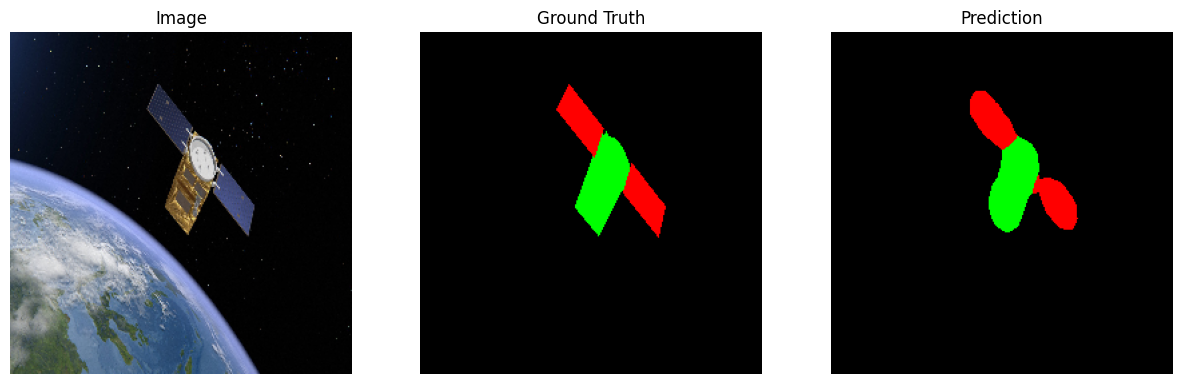

Sample 2


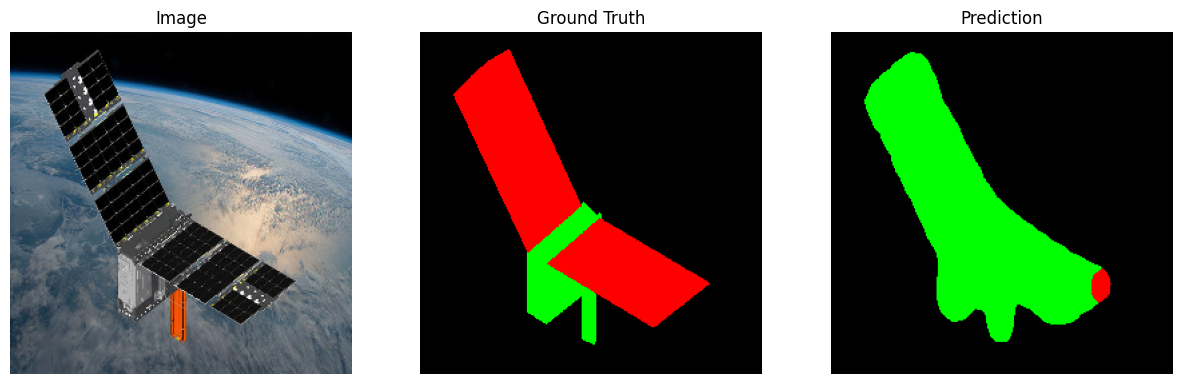

Sample 3


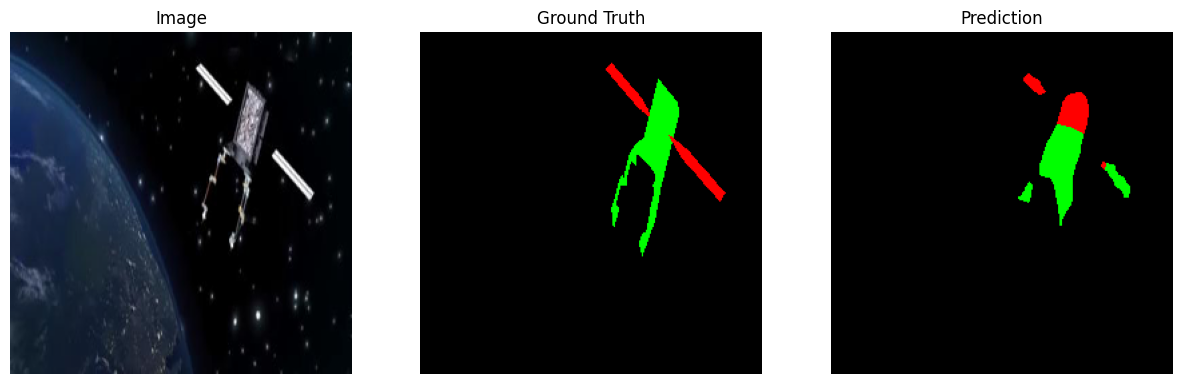

Sample 4


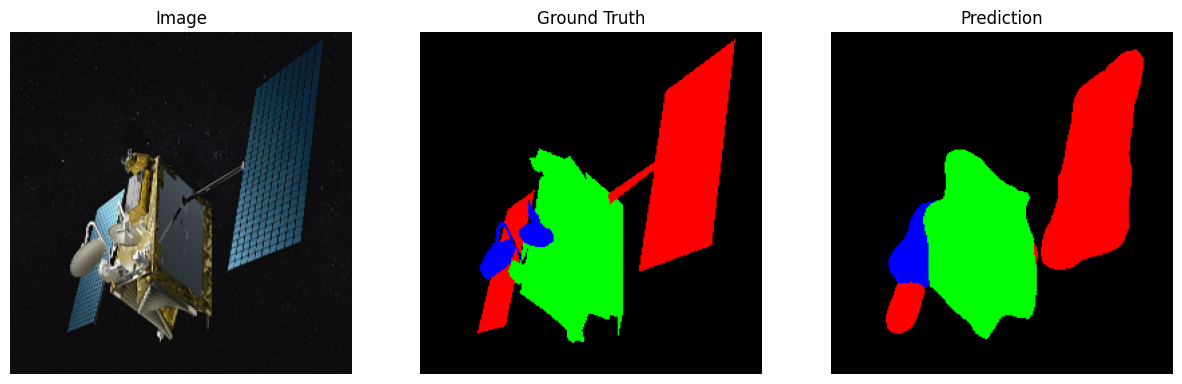

Sample 5


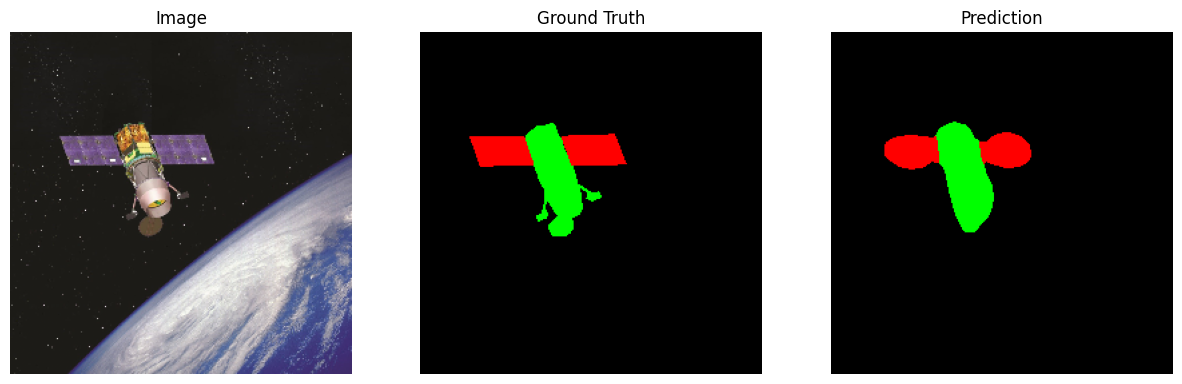

Sample 6


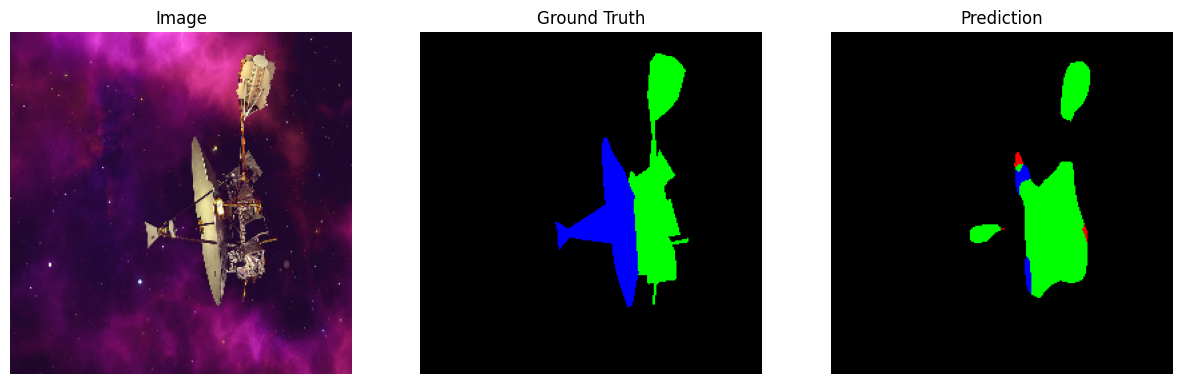

Sample 7


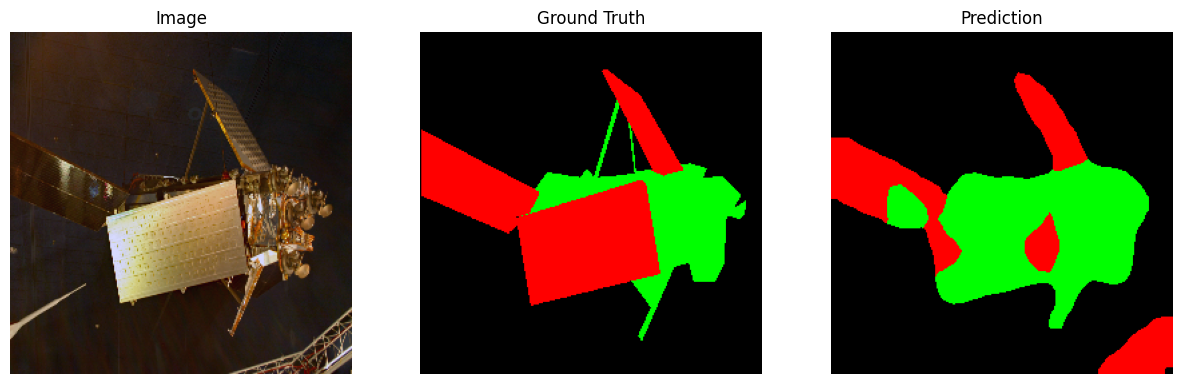

Sample 8


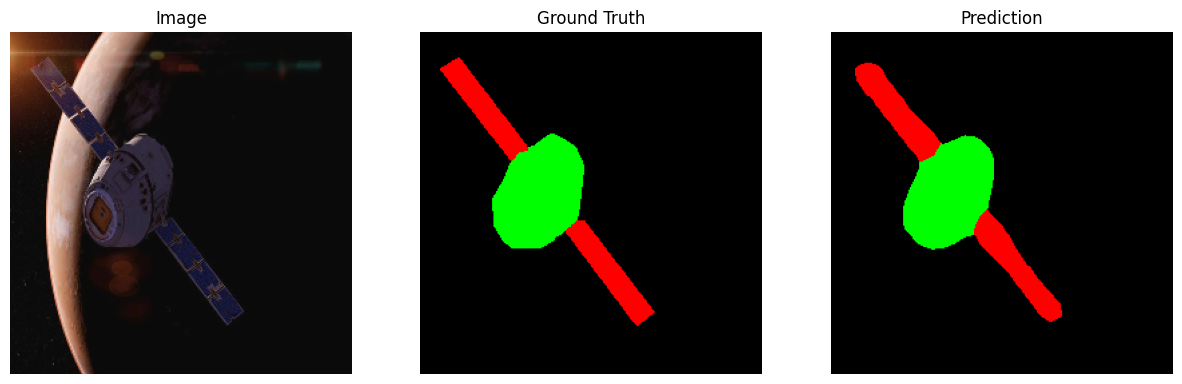

Sample 9


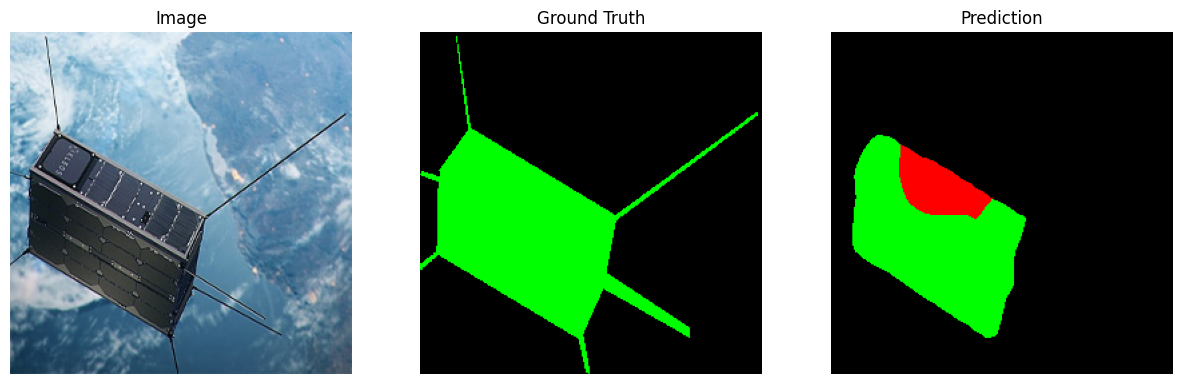

Sample 10


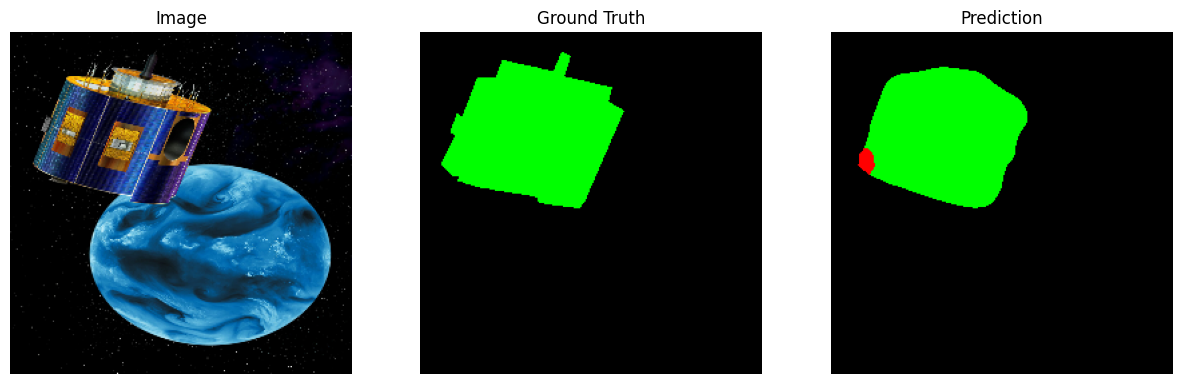

In [ ]:
model.eval()

with torch.no_grad():

    for i in range(10):    
        image, mask = dataset_val[i]

        x = image.unsqueeze(0).to(device)     # [1,3,H,W]
        logits = model(x)["out"]               # [1,4,H,W]
        pred = torch.argmax(logits, dim=1)     # [1,H,W]
        pred = pred.squeeze(0).cpu()           # [H,W]
        
        image_vis = unnormalize(image).permute(1,2,0).clamp(0,1).cpu().numpy()
        gt_vis    = colorize_mask(mask.cpu().numpy())
        pred_vis  = colorize_mask(pred.numpy())

        print(f"Sample {i+1}")

        plt.figure(figsize=(15,5))

        plt.subplot(1,3,1)
        plt.title("Image")
        plt.imshow(image_vis)
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.title("Ground Truth")
        plt.imshow(gt_vis)
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.title("Prediction")
        plt.imshow(pred_vis)
        plt.axis("off")

        plt.show()
